# Udacity Data Engineering Capstone Project - Obira Daniel
### Course 5 of 5: Udacity Data Engineering Nano Degree

#### Project Summary
#### *In a NutShell Parquet is a Hero*
Processing All US Visitors in March 2016, about 3,157,072 People from Raw SAS data to some few insights.


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
import geopandas
#import pyspark.pandas as ps
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import seaborn as sns
import sys
import os
#import contextily as cx
water = 'dodgerblue'
earth = 'tan'
from datetime import datetime, timedelta

import boto3
import configparser

config = configparser.ConfigParser()
#config.read('dwh.cfg')
#os.environ["AWS_ACCESS_KEY_ID"] = config.get("CREDENTIALS", "AWS_ACCESS_KEY_ID")
#os.environ["AWS_SECRET_ACCESS_KEY"] = config.get("CREDENTIALS", "AWS_SECRET_ACCESS_KEY")

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, lit
from pyspark.sql.functions import udf

from pyspark.sql.types import (
    StructType, 
    StructField, 
    DoubleType, 
    StringType, 
    IntegerType,
    DateType)

##### Pandas Display Settings

In [2]:
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format',  '{:,.2f}'.format)

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

 <span style="color: blue">**1. I94 migration SAS Data from the Udacity Workspace is read using pyspark, it is first converted from SAS to parquet, then columns names are improved,
  Data types cast appropriately, it is joined to other key data then it is exported to Parquet achieving a compression of over 800% for each month. 
This will be the pre-processed raw data.** </span> 

For all 40,790,529 Records, ~499 MB Parquet file instead of the ~5.92 GB SAS files (12 of them ranging from 374 MB to 684 MB), effective compression 1,215%, the same data is 12.15 times smaller and faster to read.


The Parquet data is then pushed to an S3 Bucket using Boto3 under the raw data folder ready for cleaning, analysis and mapping.

<span style="color: blue">**2. The other data, US City Demographic Data and Airport Codes are cleaned and will be mapped to the I94 data or joined, they are then uploaded to S3, this is a one off task, that data will be used each time as is.** </span>

<span style="color: blue">**3. Spatial Data (World Countries, US States and World Cities will be joined to the summarized I94 data to make simple maps using GeoPandas to quickly visually communicate quick insights), they are then uploaded to S3, this is a one off task, that data will be used each time as is.** </span> 

<span style="color: blue">**4. The parquet data is loaded to EMR using PySpark from S3 in the same region if possible same zone, where it is mapped, cleaned, analysed and any new calcuations are added to complete the full ETL.** </span>

I used the Udacity WorkSpace mainly  and my local PC for the GIS Maps because of the GeoPandas library.

At this point any additonal joins/mappings/integration can be done.

The cleaned, mapped and joined parquet data is then exported to the same S3 bucket under the final data folder because it can now be used for analysis and can be loaded straight to an OLAP or  NO SQL database.
The Data Model is then documented at this Stage.

<span style="color: blue">**5. I used March 2016 Data for the Analysis in this notebook, with 3,157,072 Visitors to US** </span> 

<span style="color: blue">**6. The summary insights of the 3,157,072 Records are joined to the spatial data to make the following maps using GeoPandas:** </span> 

    1. US Map showing summary of total vistors to US by destination State for the year 2016
    2. World Map showing passenger traffic to US for the year 2016 by Airport
    3. World Map showing passenger traffic to US for the year 2016 by Country
    4. If possible in the data model,  World Map showing passenger traffic to US for the year 2016 by City

<span style="color: blue">**7. Potential pipelines for Airflow** </span> 

    1. For Udacity Workspace: DAG1 - scheduled monthly, performs Step 1 of the workflow: Reading SAS data by month, renaming columns, casting data types to enforce a schema then writes to parquet in the workspace by month and for all months it has run as one parquet file, then uploads the base folder with all parquet data to S3.
    2. For AWS EMR and Redshift after DAG1: DAG2 - scheduled monthly, performs Steps 4, 5 and 6: An EMR Cluster reads the raw parquet data, cleans, analyses, integrates and maps columns to appropriate values then exports to S3 Parquet as final data, then also loads the data straight to redshift.

<span style="color: blue">**8. Documentation** </span> 
#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 
Data to be Used:
1. I94 Immigration Data
This data comes from the US National Tourism and Trade Office

2. Airports
Simple table of airport codes and corresponding cities


3. US Demograchics(us-cities-demographics.csv)
This data comes from OpenSoft showing the population and age group statics for several US Cities

4. CountryCodes(Country_Codes.csv)
Mapped from the I94 Immigration Data Metadata Description include Codes


5. PortCodes(Port_Codes.csv)
Mapped from the I94 Immigration Data Metadata Description include Codes

6. TransportCodes(TransportMeansCode.csv)
Mapped from the I94 Immigration Data Metadata Description include Codes

7. US_State_Codes(US_States.csv)
Mapped from the I94 Immigration Data Metadata Description include Codes

8. VisaReasonsCodes(VisaReasons.csv)
Mapped from the I94 Immigration Data Metadata Description include Codes


 GIS Data Shapefiles (GIS_Data Folder, All are in GCS_WGS_1984 Projection (EPSG:4326))
 9. All US States - All 50 US States with key attributes - From ESRI (ArcGIS hub)

 10. Cities - World Cities with key attributes - From ESRI (ArcGIS hub)

 11. Countries - World Countries with key attributes - From ESRI (ArcGIS hub)

 12. US states without Hawaii and Alaska to optimize map display extent, I processed this from all states



### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

### *2.1* *I94* *migration* *data*

In [3]:
spark = SparkSession.builder.appName("Udacity Data Eng Capstone OD")\
    .config("spark.jars.repositories", "https://repos.spark-packages.org/")\
    .config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11,org.apache.hadoop:hadoop-aws:2.7.0")\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .enableHiveSupport().getOrCreate()

#df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [4]:
Fullmonths = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

months_list= ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

#months_list = ['jan']

months_data = {'jan':'01', 'feb':'02', 'mar':'03', 'apr':'04', 
               'may':'05', 'jun':'06', 'jul':'07', 'aug':'08', 
               'sep':'09', 'oct':'10', 'nov':'11', 'dec':'12'}

##### Step 1 *Converting all SAS Data to Parquet (reduce size from ~5.92Gb to ~ 700MB)*

In [ ]:
#df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_jun16_sub.sas7bdat')
startTime = datetime.now()
totalRecords = 0
for month in months_list:
    startMonth = datetime.now()
    print(month)
    df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_{}16_sub.sas7bdat'.format(month))
    Records = df_spark.count()
    totalRecords += Records
    df_spark.write.parquet("sas_data_raw/2016/{}".format(months_data[month]))
    
    print((datetime.now() - startMonth), "time for SAS to Parquet", month, "with ", "{:,}".format(Records), " Records.")
    
print((datetime.now() - startTime), "time running for 2016 SAS to Parquet with ", "{:,}".format(totalRecords), " total Records.")

In [101]:
#write to parquet
#df_spark.write.parquet("sas_data")
#df_spark=spark.read.parquet('s3a://obirad1/sas_data_all_old/2016/03')
#df_spark=spark.read.parquet('sas_data/2016/03')

##### Step 2 *Pushing all Raw Parquet Data to S3*

In [ ]:
def upload_files_to_s3(path, bucket_name, region):
    bytes_MB = 2**20
    start = datetime.now()
    session = boto3.Session(
        aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
        region_name=region#e.g'us-east-1'
    )
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
    totalsize, count = 0, 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            count+=1
            full_path = os.path.join(subdir, file)
            totalsize += os.path.getsize(full_path)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=subdir.replace("\\", '/')+'/'+file, Body=data)
            if (count%20) == 0:
                print(file, "Uploaded, {:,} files so far uploaded, {:,.2f} MB total, {} Time running".format(count, totalsize/bytes_MB , (datetime.now() - start)))
                
    overall = str(datetime.now() - startTime) + " Time running Uploaded, {:,} files uploaded, {:,.2f} MB total.".format(count, totalsize/bytes_MB)
    print(overall)
    print("COMPLETED")
                
upload_files_to_s3("sas_data_raw", 'obirad1', 'us-east-1')

##### Step 3 *Renaming all Columns, Schema Enforcement and Joins/Integration*

##### *Joining the preprocessed raw parquet to Countries, Countres, Port,  TransportCodes, US_State_Codes, VisaReasons*
##### *This is done for all months and the updated dataframe exported to parquet, this will now be ready for EMR*

In [5]:
i94_schema = StructType([StructField('i94_id', IntegerType(), True),
                         StructField('Year', IntegerType(), True), 
                         StructField('Month', IntegerType(), True), 
                         StructField('CountryCode', IntegerType(), True), 
                         StructField('CountryResidenceCode', IntegerType(), True), 
                         StructField('AirportCode', StringType(), True), 
                         StructField('DateOfArrival', DateType(), True), 
                         StructField('ModeOfTransport', IntegerType(), True), 
                         StructField('StateCodeUS', StringType(), True), 
                         StructField('DateOfDeparture', DateType(), True), 
                         StructField('AgeYears', DoubleType(), True), 
                         StructField('VisaReason', IntegerType(), True), 
                         StructField('CountVar', IntegerType(), True), 
                         StructField('ValidAdress', StringType(), True),
                         StructField('DeleteDays', StringType(), True),
                         StructField('DeleteMexl', StringType(), True),
                         StructField('DeleteDup', StringType(), True),
                         StructField('DeleteVisa', StringType(), True),
                         StructField('DeleteRecd', StringType(), True),
                         StructField('DateAdded_I94', StringType(), True), 
                         StructField('VisaIssueDepartment', StringType(), True), 
                         StructField('OccupationUS', StringType(), True), 
                         StructField('ArrivalSituation', StringType(), True), 
                         StructField('DepartureStatus', StringType(), True), 
                         StructField('CurrentStatus', StringType(), True), 
                         StructField('MatchArrivalDeparture', StringType(), True), 
                         StructField('YearofBirth', IntegerType(), True), 
                         StructField('DateAdmittedUS', StringType(), True), 
                         StructField('Gender', StringType(), True), 
                         StructField('InsNum', StringType(), True), 
                         StructField('Airline', StringType(), True), 
                         StructField('AdminNum', IntegerType(), True), 
                         StructField('FlightNum', StringType(), True), 
                         StructField('VisaType', StringType(), True)])

In [6]:
i94s_label_map = {'cicid':'i94_id',
                  'i94yr':'Year',
                  'i94mon':'Month',
                  'i94cit':'CountryCode',
                  'i94res':'CountryResidenceCode',
                  'i94port':'AirportCode',
                  'arrdate':'DateOfArrival',
                  'i94mode':'ModeOfTransport',
                  'i94addr':'StateCodeUS',
                  'depdate':'DateOfDeparture',
                  'i94bir':'AgeYears',
                  'i94visa':'VisaReason',
                  'count':'CountVar',
                  'validres':'ValidAdress',
                  'delete_days':'DeleteDays',
                  'delete_mexl':'DeleteMexl',
                  'delete_dup':'DeleteDup',
                  'delete_visa':'DeleteVisa',
                  'delete_recdup':'DeleteRecd',
                  'dtadfile':'DateAdded_I94',
                  'visapost':'VisaIssueDepartment',
                  'occup':'OccupationUS',
                  'entdepa':'ArrivalSituation',
                  'entdepd':'DepartureStatus',
                  'entdepu':'CurrentStatus',
                  'matflag':'MatchArrivalDeparture',
                  'biryear':'YearofBirth',
                  'dtaddto':'DateAdmittedUS',
                  'gender':'Gender',
                  'insnum':'InsNum',
                  'airline':'Airline',
                  'admnum':'AdminNum',
                  'fltno':'FlightNum',
                  'visatype':'VisaType'}

i94_fields_map = ['CountryCode', 'CountryResidenceCode', 'AirportCode', 'ModeOfTransport', 'VisaReason']

date_fields = ['DateOfArrival', 'DateAdmittedUS']

In [7]:
CountryCodes = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/Country_Codes.csv',header='True')
PortCodes = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/Port_Codes.csv',header='True')
TransportCodes = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/TransportMeansCode.csv',header='True')
US_State_Codes = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/US_States.csv',header='True')
VisaReasonsCodes = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/VisaReasons.csv',header='True')

In [8]:
@udf(returnType=DateType())
def convert_to_date(days_timestamp):
    try:
        if days_timestamp > 0:
            return pd.to_datetime(days_timestamp, unit='D', origin=pd.Timestamp('1960-01-01')).date()
        else:
            return None
    except:
        return None

@udf(returnType=StringType())
def convert_to_date2(date_string):
    try:
        if date_string == 'D/S':
            return 'D/S'
        else:
            return str(pd.to_datetime(date_string, format ="%m%d%Y").date())
    except:
        return None

In [ ]:
startTime = datetime.now()
totalRecords = 0
for month in months_list:
    startMonth = datetime.now()
    print(month)
    df_spark=spark.read.parquet("sas_data_raw/2016/{}".format(months_data[month]))
    u=list(i94s_label_map[key] for key in df_spark.columns) 
    Records = df_spark.count()
    totalRecords += Records
    df_spark = df_spark.toDF(*u)
    df_spark = df_spark.withColumn("DateOfArrival", convert_to_date("DateOfArrival"))
    df_spark = df_spark.withColumn("DateOfDeparture", convert_to_date("DateOfDeparture"))
    df_spark = df_spark.withColumn("DateAdmittedUS", convert_to_date2("DateAdmittedUS"))
    
    #Casting DataTypes
    df_spark  = df_spark.withColumn('i94_id', col('i94_id').cast('Integer'))\
                        .withColumn('Year', col('Year').cast('Integer'))\
                        .withColumn('Month', col('Month').cast('Integer'))\
                        .withColumn('CountryCode', col('CountryCode').cast('Integer'))\
                        .withColumn('CountryResidenceCode', col('CountryResidenceCode').cast('Integer'))\
                        .withColumn('ModeOfTransport', col('ModeOfTransport').cast('Integer'))\
                        .withColumn('VisaReason', col('VisaReason').cast('Integer'))\
                        .withColumn('CountVar', col('CountVar').cast('Integer'))\
                        .withColumn('YearofBirth', col('YearofBirth').cast('Integer'))\
                        .withColumn('AdminNum', col('AdminNum').cast('Integer'))
    
    #Joining to the other datasets and dropping the join id Columns after
    #Another option would be to use pyspark SQL views, this is much simpler for simple joins
    df_spark = df_spark.join(US_State_Codes, df_spark.StateCodeUS == US_State_Codes.Code, "left")
    df_spark = df_spark.drop(df_spark.Code)
    df_spark = df_spark.join(CountryCodes, df_spark.CountryCode == CountryCodes.Code, "left")
    df_spark = df_spark.drop(df_spark.Code)
    df_spark = df_spark.join(TransportCodes, df_spark.ModeOfTransport == TransportCodes.Code, "left")
    df_spark = df_spark.drop(df_spark.Code)
    df_spark = df_spark.join(VisaReasonsCodes, df_spark.VisaReason == VisaReasonsCodes.Code, "left")
    df_spark = df_spark.drop(df_spark.Code)
    df_spark = df_spark.join(PortCodes, df_spark.CountryCode == PortCodes.Code, "left")
    df_spark = df_spark.drop(df_spark.Code)
    
    #Writing the Parquet Files to local Storage, they will be pushed to S3
    #df_spark.write.parquet("s3a://obirad1/Udacity/data-eng-capstone/2016/{}".format(months_data[month])
    df_spark.write.parquet("sas_data_final/2016/{}".format(months_data[month]))
    #df_spark.write.mode('append').parquet("sas_data/2016/all/2016_all_data.parquet")

    #df_spark.write.mode('append').parquet("s3a://obirad1/Udacity/data-eng-capstone/2016/all")

    print((datetime.now() - startMonth), "time running for renaming and integration", month, "with ", "{:,}".format(Records), " Records.")
    
print((datetime.now() - startTime), "time running for 2016 with ", "{:,}".format(totalRecords), " total Records.")

jan


In [ ]:
df_spark.limit(5).toPandas()

##### Step 4 *Pushing all Processed and Integrated Parquet Data to S3*

In [ ]:
upload_files_to_s3("sas_data", 'obirad1', 'us-east-1')

In [194]:
df_spark.limit(5).toPandas()

i94_id  Year  Month  CountryCode  CountryResidenceCode AirportCode  \
0  963221  2016      3          209                   209         WAS   
1  963222  2016      3          209                   209         WAS   
2  963223  2016      3          209                   209         WAS   
3  963224  2016      3          209                   209         WAS   
4  963225  2016      3          209                   209         WAS   

  DateOfArrival  ModeOfTransport StateCodeUS DateOfDeparture       ...         \
0    2016-03-06                1          DC      2016-03-09       ...          
1    2016-03-06                1          DC      2016-03-09       ...          
2    2016-03-06                1          DC      2016-03-10       ...          
3    2016-03-06                1          DC      2016-03-10       ...          
4    2016-03-06                1          DC      2016-03-10       ...          

   Airline    AdminNum  FlightNum VisaType           US_State Country  \
0       NH  2147483647      00002       WB  DIST. OF COLUMBIA   JAPAN   
1       UA  2147483647      00804       WB  DIST. OF COLUMBIA   JAPAN   
2       NH  2147483647      00002       WB  DIST. OF COLUMBIA   JAPAN   
3       NH  2147483647      00002       WB  DIST. OF COLUMBIA   JAPAN   
4       UA  2147483647      00804       WB  DIST. OF COLUMBIA   JAPAN   

  TransportMeans ReasonForVisa PortOfEntry Us_State_Country  
0            Air      Business        None             None  
1            Air      Business        None             None  
2            Air      Business        None             None  
3            Air      Business        None             None  
4            Air      Business        None             None  

[5 rows x 34 columns]

In [ ]:
#final_raw = spark.createDataFrame(df_spark_final_raw.rdd, i94_schema)

In [195]:
df_spark.printSchema()

root
 |-- i94_id: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- CountryCode: integer (nullable = true)
 |-- CountryResidenceCode: integer (nullable = true)
 |-- AirportCode: string (nullable = true)
 |-- DateOfArrival: date (nullable = true)
 |-- ModeOfTransport: integer (nullable = true)
 |-- StateCodeUS: string (nullable = true)
 |-- DateOfDeparture: date (nullable = true)
 |-- AgeYears: integer (nullable = true)
 |-- VisaReason: integer (nullable = true)
 |-- CountVar: integer (nullable = true)
 |-- DateAdded_I94: string (nullable = true)
 |-- VisaIssueDepartment: string (nullable = true)
 |-- OccupationUS: string (nullable = true)
 |-- ArrivalSituation: string (nullable = true)
 |-- DepartureStatus: string (nullable = true)
 |-- CurrentStatus: string (nullable = true)
 |-- MatchArrivalDeparture: string (nullable = true)
 |-- YearofBirth: integer (nullable = true)
 |-- DateAdmittedUS: string (nullable = true)
 |-- Gender: s

In [196]:
'{:,} Records in Spark DataFrame'.format(df_spark.count())

'3,157,072 Records in Spark DataFrame'

#### *2.2* *US* *City* *Demographic* *Data*

In [142]:
us_demographics = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/us-cities-demographics.csv', sep=";", header='True')

In [143]:
us_demographics.limit(5).toPandas()

City          State Median Age Male Population  \
0     Silver Spring       Maryland       33.8           40601   
1            Quincy  Massachusetts       41.0           44129   
2            Hoover        Alabama       38.5           38040   
3  Rancho Cucamonga     California       34.5           88127   
4            Newark     New Jersey       34.6          138040   

  Female Population Total Population Number of Veterans Foreign-born  \
0             41862            82463               1562        30908   
1             49500            93629               4147        32935   
2             46799            84839               4819         8229   
3             87105           175232               5821        33878   
4            143873           281913               5829        86253   

  Average Household Size State Code                       Race  Count  
0                    2.6         MD         Hispanic or Latino  25924  
1                   2.39         MA                      White  58723  
2                   2.58         AL                      Asian   4759  
3                   3.18         CA  Black or African-American  24437  
4                   2.73         NJ                      White  76402

In [145]:
us_demographics.describe().toPandas()

summary     City      State         Median Age     Male Population  \
0   count     2891       2891               2891                2888   
1    mean     None       None  35.49488066413016   97328.42624653739   
2  stddev     None       None  4.401616730099886  216299.93692873296   
3     min  Abilene    Alabama               22.9              100135   
4     max     Yuma  Wisconsin               70.5               99967   

    Female Population    Total Population Number of Veterans  \
0                2888                2891               2878   
1  101769.63088642659  198966.77931511588  9367.832522585128   
2  231564.57257148277   447555.9296335903  13211.21992386408   
3              100260              100247              10001   
4               99430               99897               9988   

         Foreign-born Average Household Size State Code  \
0                2878                   2875       2891   
1  40653.598679638635      2.742542608695655       None   
2   155749.1036650984     0.4332910878973046       None   
3               10024                    2.0         AK   
4                9929                   4.98         WI   

                                Race               Count  
0                               2891                2891  
1                               None   48963.77447250087  
2                               None  144385.58856460615  
3  American Indian and Alaska Native              100055  
4                              White               99948

#### *2.3* *Airport Codes*  *Data*

In [6]:
Airports = pd.read_csv(r'Mapping\Airports_Processed.csv',header=0)

In [7]:
Airports.head()

Unnamed: 0 ident                                name continent iso_country  \
0           0   00A                   Total Rf Heliport       NaN          US   
1           1  00AA                Aero B Ranch Airport       NaN          US   
2           2  00AK                        Lowell Field       NaN          US   
3           3  00AL                        Epps Airpark       NaN          US   
4           4  00AR  Newport Hospital & Clinic Heliport       NaN          US   

   municipality iata_code local_code     lat  long  
0      Bensalem       NaN        00A  -74.93 40.07  
1         Leoti       NaN       00AA -101.47 38.70  
2  Anchor Point       NaN       00AK -151.70 59.95  
3       Harvest       NaN       00AL  -86.77 34.86  
4       Newport       NaN        NaN  -91.25 35.61

In [10]:
Airports.describe(include="all")

Unnamed: 0  ident                         name continent iso_country  \
count    55,075.00  55075                        55075     27356       54828   
unique         NaN  55075                        52144         6         243   
top            NaN    00A  Centre Hospitalier Heliport        EU          US   
freq           NaN      1                           85      7840       22757   
mean     27,537.00    NaN                          NaN       NaN         NaN   
std      15,898.93    NaN                          NaN       NaN         NaN   
min           0.00    NaN                          NaN       NaN         NaN   
25%      13,768.50    NaN                          NaN       NaN         NaN   
50%      27,537.00    NaN                          NaN       NaN         NaN   
75%      41,305.50    NaN                          NaN       NaN         NaN   
max      55,074.00    NaN                          NaN       NaN         NaN   

       municipality iata_code local_code       lat      long  
count         49399      9189      28686 55,075.00 55,075.00  
unique        27133      9042      27436       NaN       NaN  
top           Seoul         0        AMA       NaN       NaN  
freq            404        80          5       NaN       NaN  
mean            NaN       NaN        NaN    -35.08     25.69  
std             NaN       NaN        NaN     79.74     27.20  
min             NaN       NaN        NaN   -179.88    -90.00  
25%             NaN       NaN        NaN    -92.01      8.02  
50%             NaN       NaN        NaN    -72.13     36.47  
75%             NaN       NaN        NaN     14.82     43.74  
max             NaN       NaN        NaN    179.98     89.50

#### *2.4.1 World Countries (Spatial Data), 252 Countries*

In [83]:
worldpath = r'GIS_Data\Countries\WorldCountries.shp'
world = geopandas.read_file(worldpath)

In [13]:
world[['LABELRANK', 'NAME', 'NAME_LONG', 'ABBREV',
       'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY',
       'INCOME_GRP', 'ISO_A2', 'ISO_A3', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB']].head()

LABELRANK       NAME  NAME_LONG   ABBREV        POP_EST  POP_RANK  \
0          2  Indonesia  Indonesia    Indo. 270,625,568.00        17   
1          3   Malaysia   Malaysia   Malay.  31,949,777.00        15   
2          2      Chile      Chile    Chile  18,952,038.00        14   
3          3    Bolivia    Bolivia  Bolivia  11,513,100.00        14   
4          2       Peru       Peru     Peru  32,510,453.00        15   

   POP_YEAR   GDP_MD  GDP_YEAR                   ECONOMY  \
0      2019  1119190      2019  4. Emerging region: MIKT   
1      2019   364681      2019      6. Developing region   
2      2019   282318      2019   5. Emerging region: G20   
3      2019    40895      2019   5. Emerging region: G20   
4      2019   226848      2019   5. Emerging region: G20   

               INCOME_GRP ISO_A2 ISO_A3      CONTINENT REGION_UN  \
0  4. Lower middle income     ID    IDN           Asia      Asia   
1  3. Upper middle income     MY    MYS           Asia      Asia   
2  3. Upper middle income     CL    CHL  South America  Americas   
3  4. Lower middle income     BO    BOL  South America  Americas   
4  3. Upper middle income     PE    PER  South America  Americas   

            SUBREGION                  REGION_WB  
0  South-Eastern Asia        East Asia & Pacific  
1  South-Eastern Asia        East Asia & Pacific  
2       South America  Latin America & Caribbean  
3       South America  Latin America & Caribbean  
4       South America  Latin America & Caribbean

In [ ]:
#world[world['NAME']=='Uganda']['geometry'].area

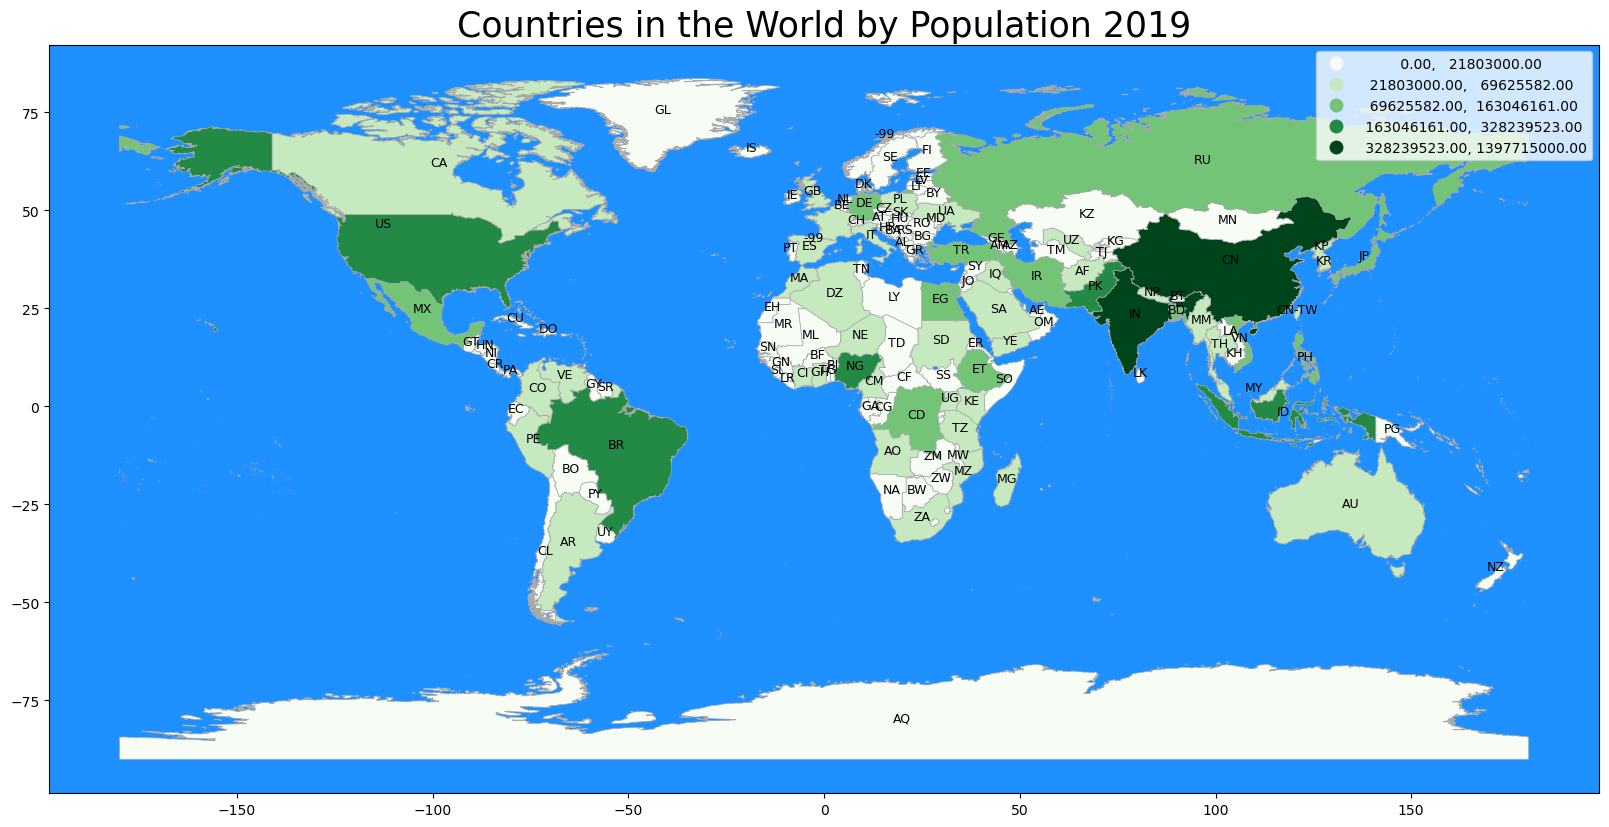

In [14]:
fig, ax = plt.subplots(figsize=(20, 15))
#world.plot('NAME', legend=False, ax=ax)
world.plot('POP_EST', legend=True, scheme='NaturalBreaks', ax=ax, cmap="Greens", edgecolor="darkgrey", linewidth=0.5)
#world.boundary.plot('Greys_r', ax=ax, linewidth=0.5)
world.apply(lambda x: ax.annotate(text=x['ISO_A2'] if x['geometry'].area >3 else '', xy=x.geometry.centroid.coords[0], ha='center', fontsize=9), axis=1);
ax.set_title('Countries in the World by Population 2019', fontdict={'fontsize':25, 'fontweight':3});
ax.set_facecolor(water)

#### *2.4.2 US States (Spatial Data), 48 States (Alaska and Hawaii Dropped) + DC*

In [15]:
uspath = r'GIS_Data\US\US_States.shp'
usa = geopandas.read_file(uspath)

In [17]:
usa[['GID_1','NAME_1','TYPE_1', 'HASC_1', 'ISO_1', 'StateUS']].head()

GID_1      NAME_1 TYPE_1 HASC_1  ISO_1 StateUS
0  USA.1_1     Alabama  State  US.AL  US-AL      AL
1  USA.3_1     Arizona  State  US.AZ  US-AZ      AZ
2  USA.4_1    Arkansas  State  US.AR  US-AR      AR
3  USA.5_1  California  State  US.CA  US-CA      CA
4  USA.6_1    Colorado  State  US.CO  US-CO      CO

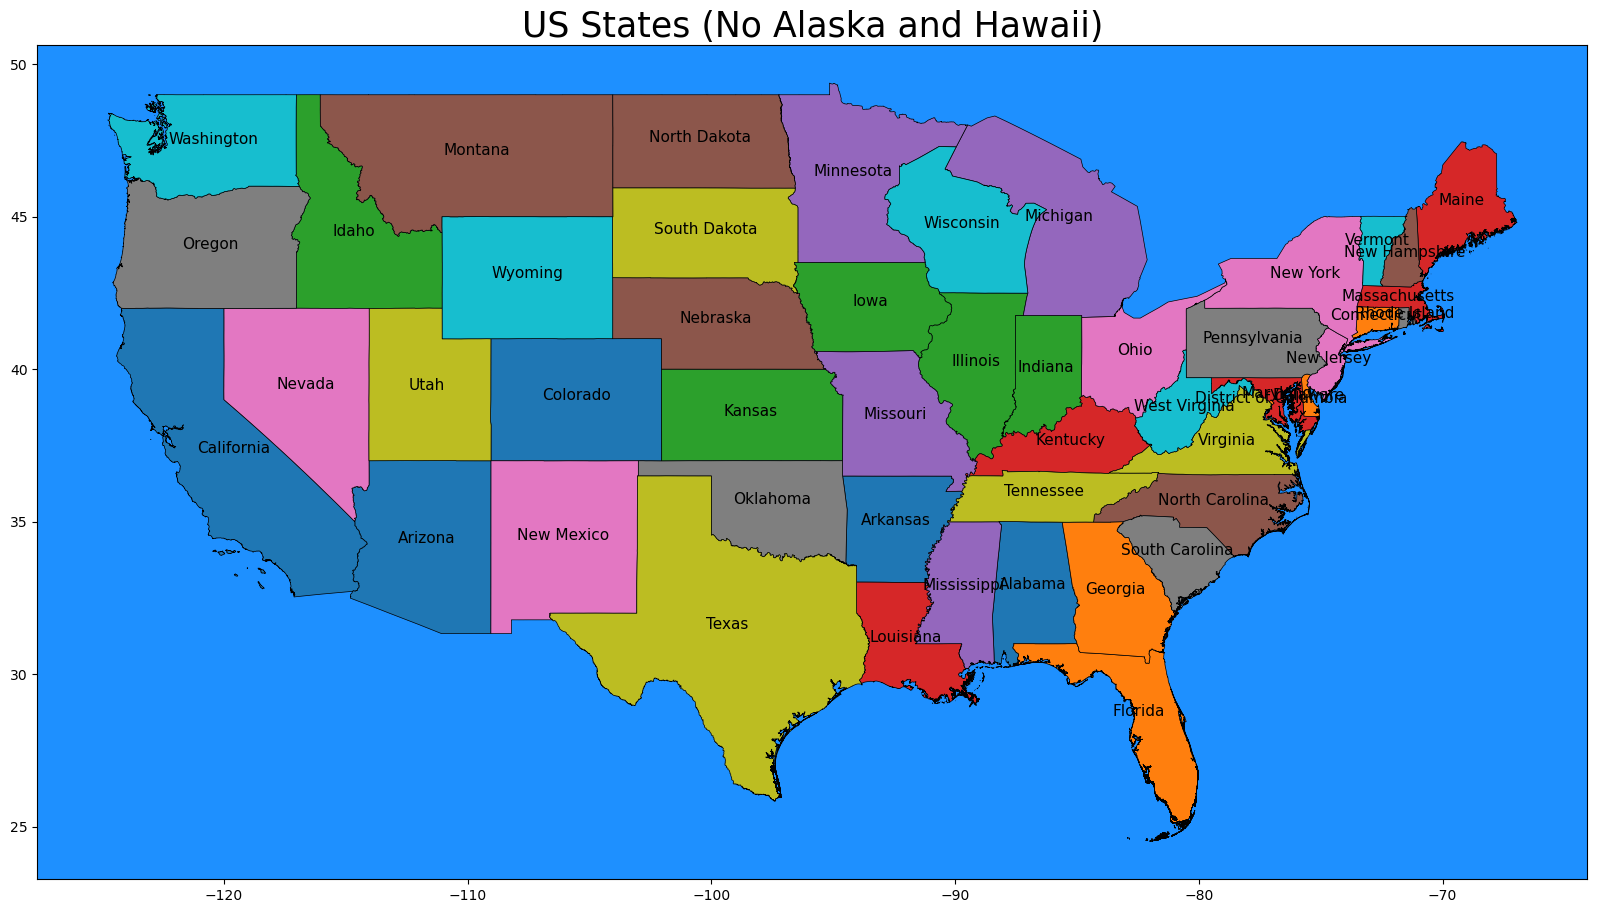

In [18]:
fig, ax = plt.subplots(figsize=(20, 15))
usa.plot('StateUS', legend=False, ax=ax, edgecolor="black", linewidth=.5)
usa.apply(lambda x: ax.annotate(text=x['NAME_1'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=11), axis=1);
ax.set_title('US States (No Alaska and Hawaii)', fontdict={'fontsize':25, 'fontweight':3});
ax.set_facecolor(water)

#### *2.4.3 World Cities Data 2,540 Cities from 231 Countries*

In [81]:
worldcities = r'GIS_Data\Cities\WorldCities.shp'
cities = geopandas.read_file(worldcities)

In [21]:
cities.head()

FID_1  OBJECTID             CITY_NAME GMI_ADMIN          ADMIN_NAME  \
0      1         1                Cuiaba   BRA-MGR         Mato Grosso   
1      2         2              Brasilia   BRA-DFD    Distrito Federal   
2      3         3               Goiania   BRA-GOI               Goias   
3      4         4          Campo Grande   BRA-MGD  Mato Grosso do Sul   
4      5         5  Pedro Juan Caballero   PRY-AMM             Amambay   

  FIPS_CNTRY CNTRY_NAME                           STATUS      POP  POP_RANK  \
0         BR     Brazil               Provincial capital   540814         3   
1         BR     Brazil  National and provincial capital  2481272         2   
2         BR     Brazil               Provincial capital  1297154         2   
3         BR     Brazil               Provincial capital   776242         3   
4         PA   Paraguay               Provincial capital        0         0   

                POP_CLASS  PORT_ID  LABEL_FLAG         POP_SOURCE  \
0      500,000 to 999,999        0           0  UN_Data_2010_2020   
1  1,000,000 to 4,999,999        0           0  UN_Data_2010_2020   
2  1,000,000 to 4,999,999        0           0  UN_Data_2010_2020   
3      500,000 to 999,999        0           0  UN_Data_2010_2020   
4                    None        0           0               None   

                      geometry  
0  POINT (-56.09300 -15.61500)  
1  POINT (-47.89775 -15.79211)  
2  POINT (-49.25500 -16.72700)  
3  POINT (-54.61600 -20.45100)  
4  POINT (-55.74800 -22.53300)

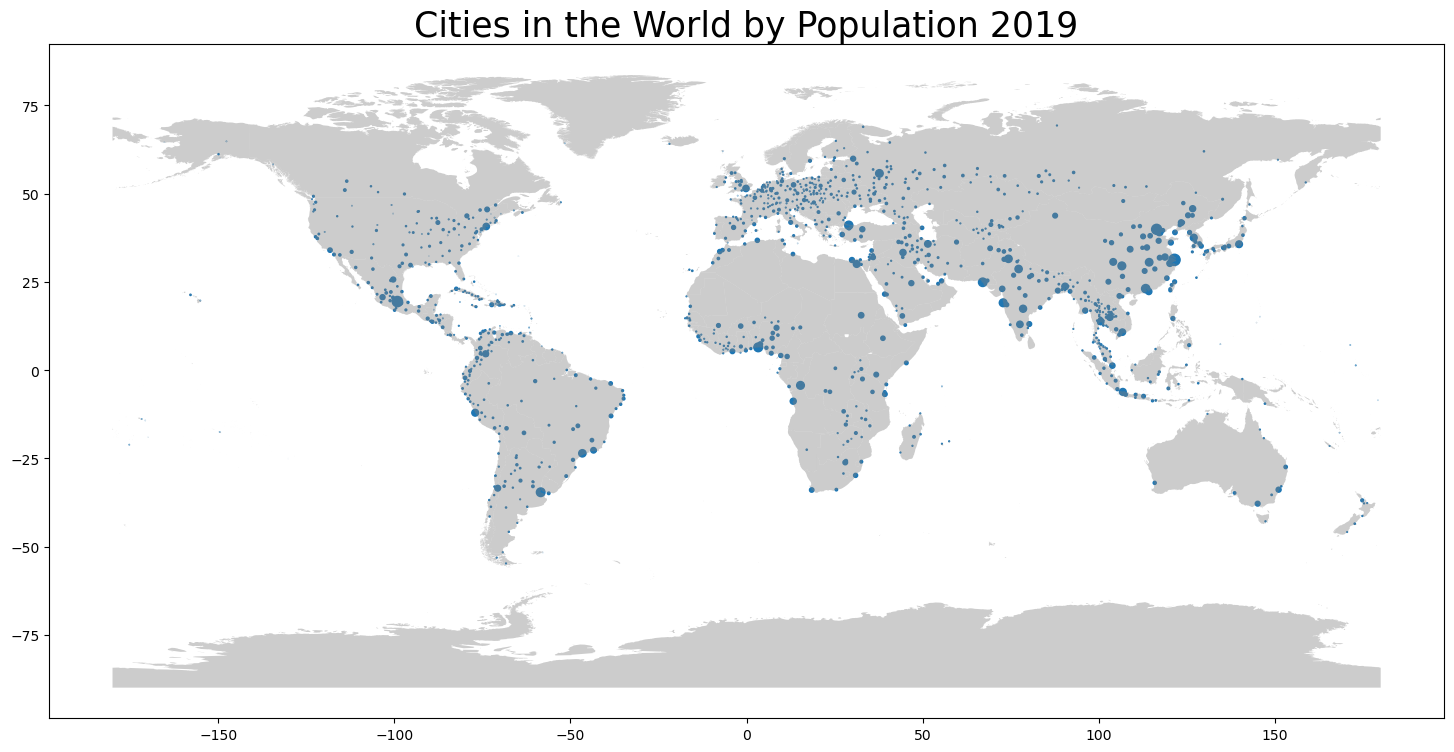

In [84]:
fig, ax = plt.subplots(figsize=(18, 12))
cities.plot(markersize=cities['POP']/400000, legend=False, ax=ax)
world.plot(ax=ax, alpha=0.4, color="grey")
#world.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);
ax.set_title('Cities in the World by Population 2019', fontdict={'fontsize':25, 'fontweight':3});

#### *Will use March for analysis (This can be replicated on Each Month or the whole dataset on EMR)*

In [103]:
df_spark=spark.read.parquet("sas_data_final/2016/03")

In [ ]:
"""
i94_fields_map = ['CountryCode', 'CountryResidenceCode', 'AirportCode', 'ModeOfTransport', 'VisaReason']

TransportModeMap = {1:'Air', 2:'Sea', 3:'Land', 9:'Not Reported'}

VisaReasonMap = {1:'Business', 2:'Pleasure', 3:'Student'}

us_states_file = r"Mapping\US_States.txt"
port_codes_file = r"Mapping\Port_Codes.txt"
countries_file = r"Mapping\Country_Codes.txt"

def mapfile(file, KeyType):
    map_dic = {}
    
    with open(file) as data:
        for line in data:
            try:
                code, value = line.split('=')
                if "'" in code:
                    code = code.replace("'","")
                    
                code = code.strip()
                if "'" in value:
                    value = value.replace("'","")
                value = value.strip()
                
                if KeyType == 'String':
                    map_dic[code] = value
                elif KeyType == 'Integer':
                    map_dic[int(code)] = value
                    
            except Exception as e:
                print(line, e )
                continue
            
    return map_dic

StateCodes_dic = mapfile(us_states_file, 'String')
CountryCodes_dic = mapfile(countries_file, 'Integer')
PortCodes_dic = mapfile(port_codes_file, 'String')
"""

In [ ]:
#TransportModeMap_bc = spark.sparkContext.broadcast(TransportModeMap)
#VisaReasonMap_bc = spark.sparkContext.broadcast(VisaReasonMap)
#StateCodes_bc = spark.sparkContext.broadcast(StateCodes_dic)
#CountryCodes_bc = spark.sparkContext.broadcast(CountryCodes_dic)
#PortCodes_bc = spark.sparkContext.broadcast(PortCodes_dic)

In [149]:
#check for duplicates
distinct_count = df_spark.distinct().count()
count = df_spark.count()
if  distinct_count == count:
    print("No Duplicates")
else:
    print("Duplicates are there, ", abs(distinct_count - count), "Records.")

No Duplicates


In [120]:
df_spark.limit(5).toPandas()

i94_id  Year  Month  CountryCode  CountryResidenceCode AirportCode  \
0  963221  2016      3          209                   209         WAS   
1  963222  2016      3          209                   209         WAS   
2  963223  2016      3          209                   209         WAS   
3  963224  2016      3          209                   209         WAS   
4  963225  2016      3          209                   209         WAS   

  DateOfArrival  ModeOfTransport StateCodeUS DateOfDeparture       ...         \
0    2016-03-06                1          DC      2016-03-09       ...          
1    2016-03-06                1          DC      2016-03-09       ...          
2    2016-03-06                1          DC      2016-03-10       ...          
3    2016-03-06                1          DC      2016-03-10       ...          
4    2016-03-06                1          DC      2016-03-10       ...          

   Airline    AdminNum  FlightNum VisaType           US_State Country  \
0       NH  2147483647      00002       WB  DIST. OF COLUMBIA   JAPAN   
1       UA  2147483647      00804       WB  DIST. OF COLUMBIA   JAPAN   
2       NH  2147483647      00002       WB  DIST. OF COLUMBIA   JAPAN   
3       NH  2147483647      00002       WB  DIST. OF COLUMBIA   JAPAN   
4       UA  2147483647      00804       WB  DIST. OF COLUMBIA   JAPAN   

  TransportMeans ReasonForVisa PortOfEntry Us_State_Country  
0            Air      Business        None             None  
1            Air      Business        None             None  
2            Air      Business        None             None  
3            Air      Business        None             None  
4            Air      Business        None             None  

[5 rows x 34 columns]

In [150]:
df_spark.printSchema()

root
 |-- i94_id: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- CountryCode: integer (nullable = true)
 |-- CountryResidenceCode: integer (nullable = true)
 |-- AirportCode: string (nullable = true)
 |-- DateOfArrival: date (nullable = true)
 |-- ModeOfTransport: integer (nullable = true)
 |-- StateCodeUS: string (nullable = true)
 |-- DateOfDeparture: date (nullable = true)
 |-- AgeYears: integer (nullable = true)
 |-- VisaReason: integer (nullable = true)
 |-- CountVar: integer (nullable = true)
 |-- DateAdded_I94: string (nullable = true)
 |-- VisaIssueDepartment: string (nullable = true)
 |-- OccupationUS: string (nullable = true)
 |-- ArrivalSituation: string (nullable = true)
 |-- DepartureStatus: string (nullable = true)
 |-- CurrentStatus: string (nullable = true)
 |-- MatchArrivalDeparture: string (nullable = true)
 |-- YearofBirth: integer (nullable = true)
 |-- DateAdmittedUS: string (nullable = true)
 |-- Gender: s

#### *2.3 I94 migration data Exploration, Cleaning, Mapping and Integration Options*

##### *2.1.1  Cleaning I94 data, (Missing Data and Wrong Values)*

In [121]:
categorical = [
 'AirportCode',
 'VisaIssueDepartment',
 'OccupationUS',
 'ArrivalSituation',
 'DepartureStatus',
 'CurrentStatus',
 'MatchArrivalDeparture',
 'Gender',
 'Airline',
 'VisaType',
 'US_State',
 'Country',
 'TransportMeans',
 'ReasonForVisa',
 'PortOfEntry',
 'Us_State_Country',
 'DateOfArrival']

In [7]:
numbers = ['AgeYears','YearofBirth']

In [8]:
df_spark.limit(5).toPandas()

i94_id  Year  Month  CountryCode  CountryResidenceCode AirportCode  \
0  963221  2016      3          209                   209         WAS   
1  963222  2016      3          209                   209         WAS   
2  963223  2016      3          209                   209         WAS   
3  963224  2016      3          209                   209         WAS   
4  963225  2016      3          209                   209         WAS   

  DateOfArrival  ModeOfTransport StateCodeUS DateOfDeparture       ...         \
0    2016-03-06                1          DC      2016-03-09       ...          
1    2016-03-06                1          DC      2016-03-09       ...          
2    2016-03-06                1          DC      2016-03-10       ...          
3    2016-03-06                1          DC      2016-03-10       ...          
4    2016-03-06                1          DC      2016-03-10       ...          

   Airline    AdminNum  FlightNum VisaType           US_State Country  \
0       NH  2147483647      00002       WB  DIST. OF COLUMBIA   JAPAN   
1       UA  2147483647      00804       WB  DIST. OF COLUMBIA   JAPAN   
2       NH  2147483647      00002       WB  DIST. OF COLUMBIA   JAPAN   
3       NH  2147483647      00002       WB  DIST. OF COLUMBIA   JAPAN   
4       UA  2147483647      00804       WB  DIST. OF COLUMBIA   JAPAN   

  TransportMeans ReasonForVisa PortOfEntry Us_State_Country  
0            Air      Business        None             None  
1            Air      Business        None             None  
2            Air      Business        None             None  
3            Air      Business        None             None  
4            Air      Business        None             None  

[5 rows x 34 columns]

In [105]:
df_spark[numbers].describe().toPandas()

summary           AgeYears        YearofBirth
0   count            3156188            3156188
1    mean  39.29775761139704  1976.702242388603
2  stddev  17.66352066223753  17.66352066223585
3     min               -2.0                204
4     max             1812.0               2018

In [28]:
df_spark.createOrReplaceTempView("Analysis")

In [31]:
spark.sql("SELECT AgeYears from Analysis ORDER BY AgeYears DESC LIMIT 5 ").toPandas()

AgeYears
0  1,812.00
1  1,812.00
2    116.00
3    115.00
4    114.00

In [34]:
spark.sql("SELECT AgeYears from Analysis  WHERE AgeYears IS NOT NULL ORDER BY AgeYears ASC LIMIT 5 ").toPandas()

AgeYears
0     -2.00
1      0.00
2      0.00
3      0.00
4      0.00

In [55]:
spark.sql("SELECT YearofBirth from Analysis ORDER BY YearofBirth DESC LIMIT 5 ").toPandas()

YearofBirth
0         2018
1         2016
2         2016
3         2016
4         2016

In [57]:
spark.sql("SELECT YearofBirth from Analysis WHERE YearofBirth IS NOT NULL ORDER BY YearofBirth ASC LIMIT 5 ").toPandas()

YearofBirth
0          204
1          204
2         1900
3         1901
4         1902

##### *AgeYears of -2 and 1,812 will be replace with None, similarly YearofBirth of 204 and 2018*

In [60]:
df_spark[numbers].describe().toPandas()

summary           AgeYears        YearofBirth
0   count            3156188            3156188
1    mean  39.29775761139704  1976.702242388603
2  stddev  17.66352066223753  17.66352066223585
3     min               -2.0                204
4     max             1812.0               2018

In [106]:
@udf(returnType=IntegerType())
def ageupdate(age):
    try:
        age=int(age)
        if (120 > age) and (age >=0):
            return age
        else:
            return None
    except:
        return None
    
@udf(returnType=IntegerType())
def yearupdate(year):
    try:
        #year=int(year)
        if (2017 > year) and (year >=1896):
            return year
        else:
            return None
    except:
        return None

In [108]:
df_spark = df_spark.withColumn("AgeYears", ageupdate("AgeYears"))

In [109]:
df_spark = df_spark.withColumn("YearofBirth", yearupdate("YearofBirth"))

In [18]:
#import pyspark.sql.functions as f
#my_list = df.select(f.collect_list('name')).first()[0]
#df_spark.select(F.collect_list('Gender')).first()[0]

Plotting AgeYears : Variable 1.
Plotting YearofBirth : Variable 2.


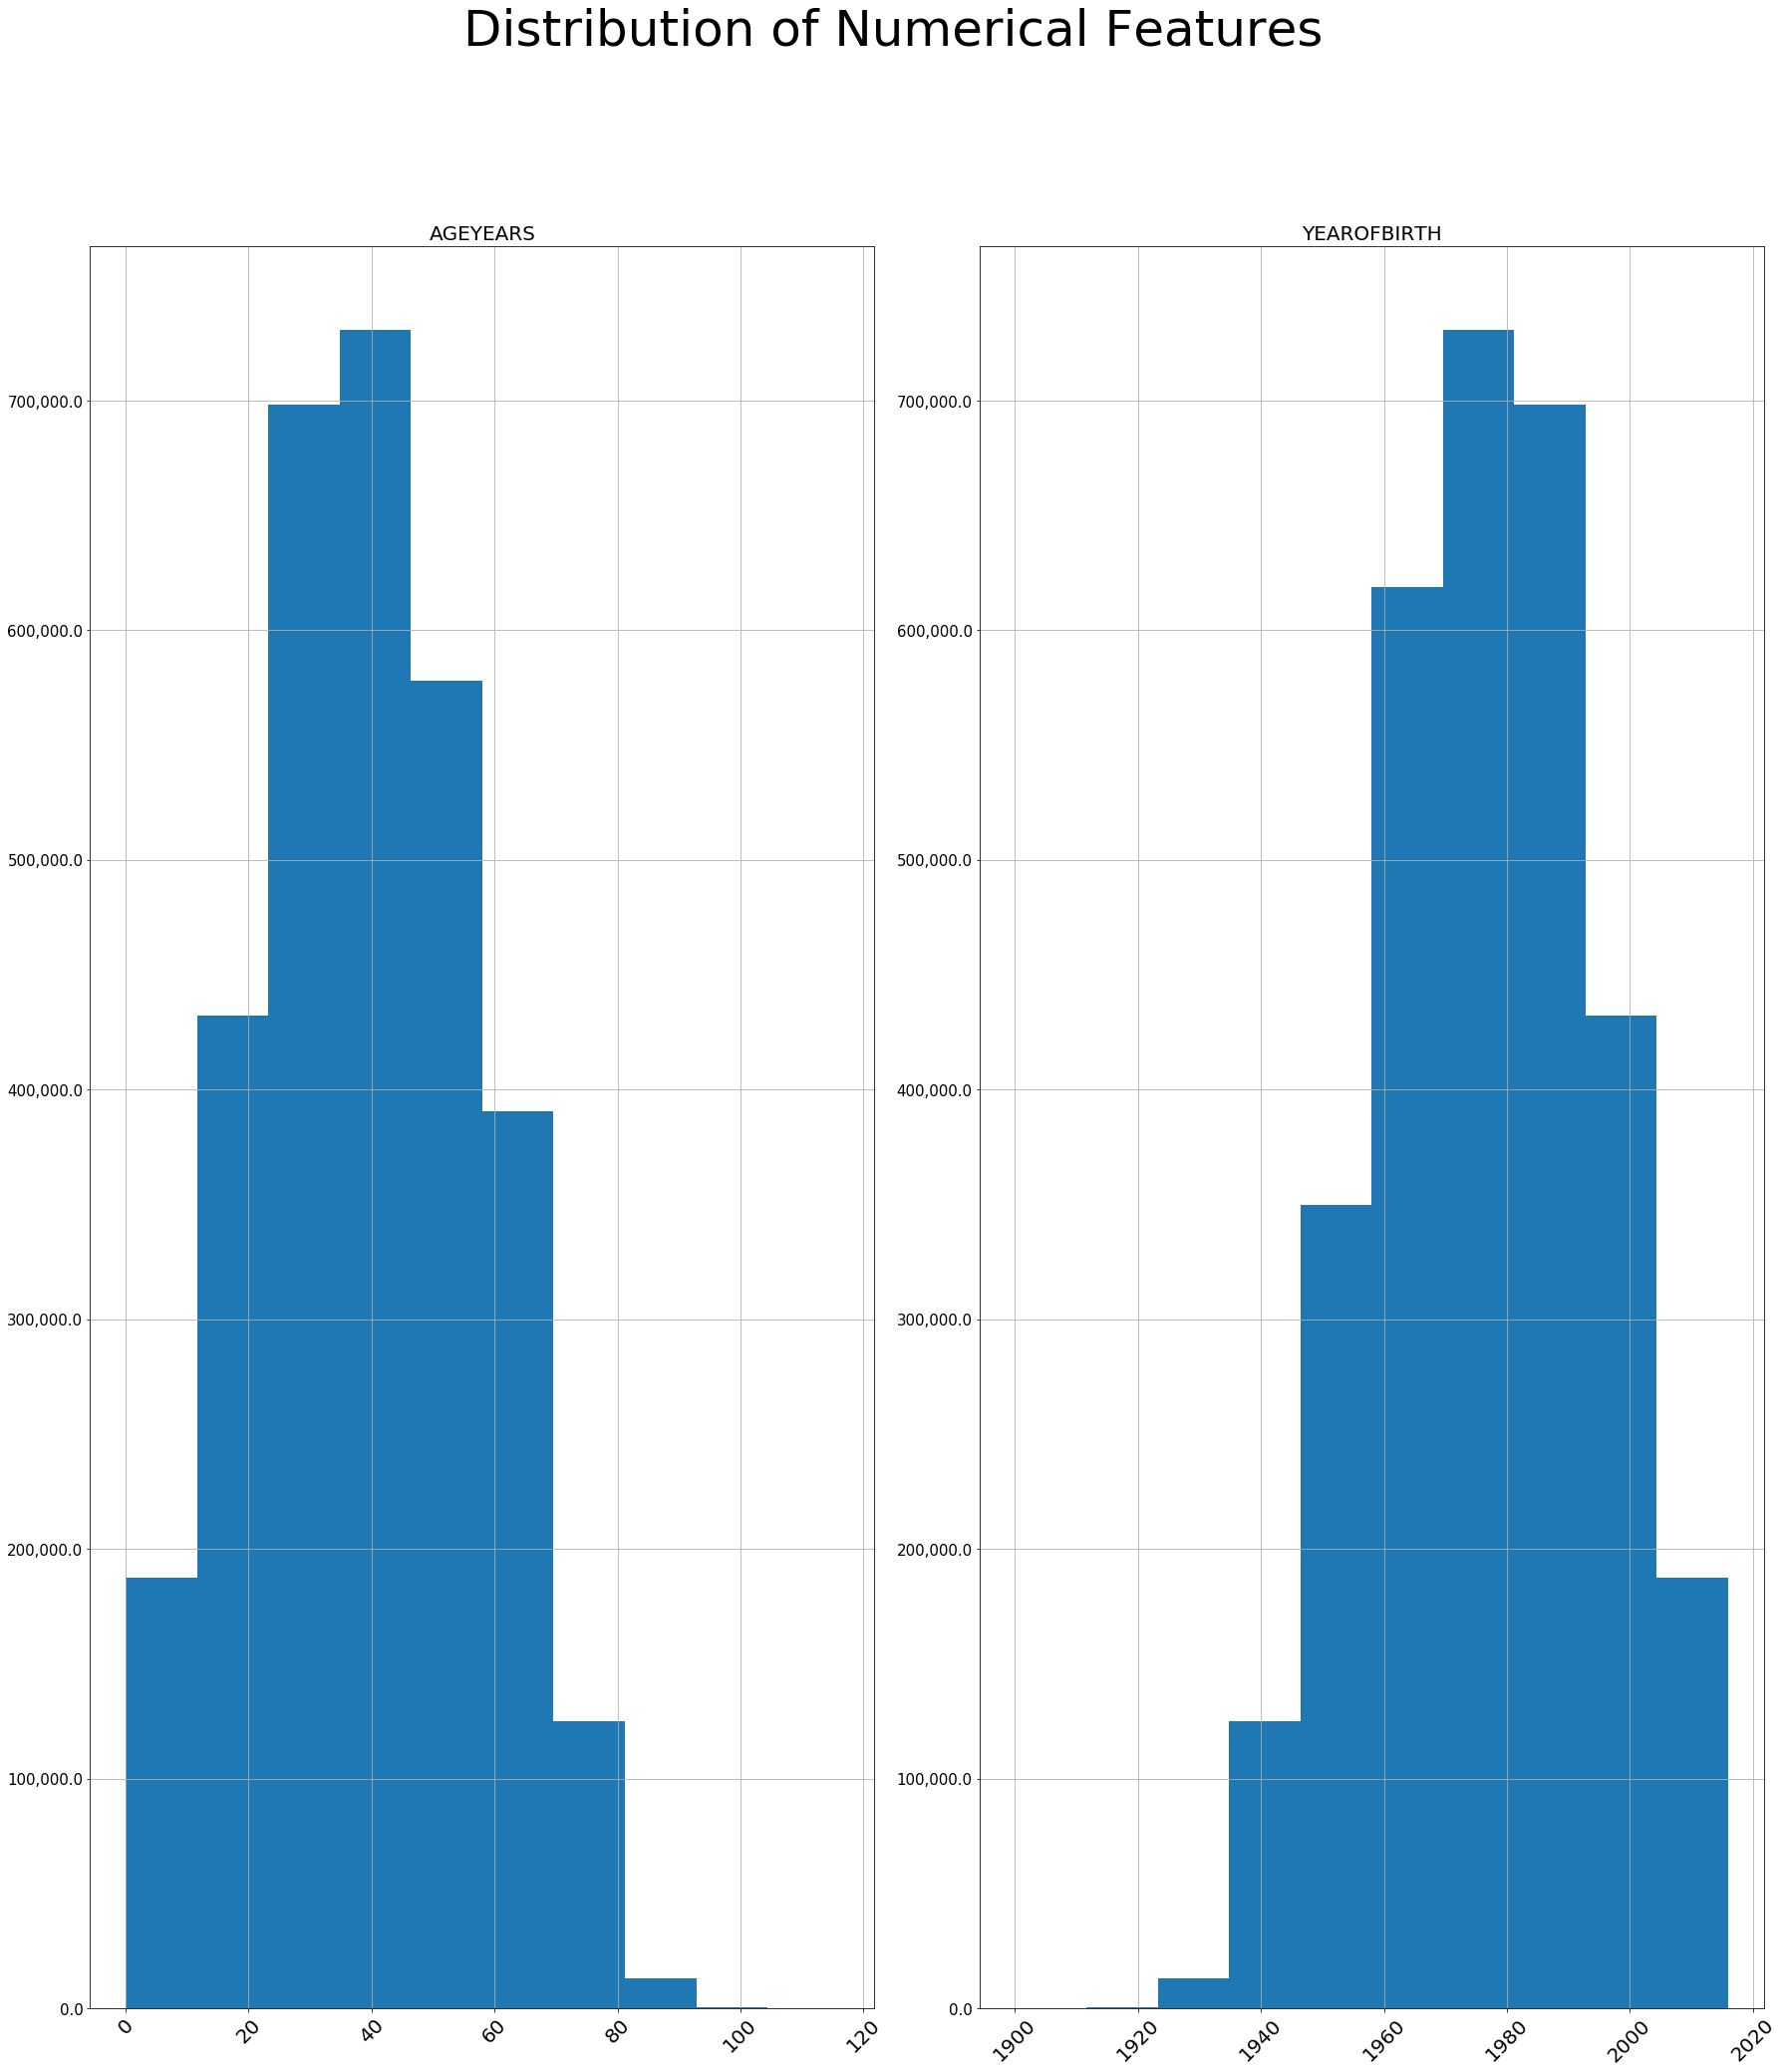

In [111]:
#Distribution of Numerical Data
fig = plt.figure(figsize=(25, 30))
st = fig.suptitle("Distribution of Numerical Features", fontsize=50, verticalalignment="center")
for col, num in zip(numbers, range(1,len(numbers)+1)):
    print("Plotting", col, ": Variable {}.".format(num))
    ax = fig.add_subplot(1,2, num)
    ax.hist(df_spark.select(F.collect_list(col)).first()[0])
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
    plt.grid(True)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [11]:
df_spark[categorical].describe().toPandas()

summary AirportCode VisaIssueDepartment        OccupationUS  \
0   count     3157072             1246740               13991   
1    mean        None               999.0               941.8   
2  stddev        None                 0.0  177.56619567404672   
3     min         5KE                 999                 200   
4     max         YSL                 ZZZ                 WTR   

  ArrivalSituation DepartureStatus CurrentStatus MatchArrivalDeparture  \
0          3156918         3020248           375               3020248   
1             None            None          None                  None   
2             None            None          None                  None   
3                A               D             U                     M   
4                Z               W             U                     M   

    Gender             Airline VisaType  US_State      Country TransportMeans  \
0  2783754             3055499  3157072   2967024      2730443        3156914   
1     None  43.200394716866555     None      None         None           None   
2     None   141.6019769364146     None      None         None           None   
3        F                 *FF       B1   ALABAMA  AFGHANISTAN            Air   
4        X                  ZZ       WT  WYOMING      ZIMBABWE            Sea   

  ReasonForVisa PortOfEntry Us_State_Country  
0       3157072           0                0  
1          None        None             None  
2          None        None             None  
3      Business        None             None  
4       Student        None             None

Plotting AirportCode : Variable 1.
Plotting VisaIssueDepartment : Variable 2.
Plotting OccupationUS : Variable 3.
Plotting ArrivalSituation : Variable 4.
Plotting DepartureStatus : Variable 5.
Plotting CurrentStatus : Variable 6.
Plotting MatchArrivalDeparture : Variable 7.
Plotting Gender : Variable 8.
Plotting Airline : Variable 9.
Plotting VisaType : Variable 10.
Plotting US_State : Variable 11.
Plotting Country : Variable 12.
Plotting TransportMeans : Variable 13.
Plotting ReasonForVisa : Variable 14.
Plotting PortOfEntry : Variable 15.
Plotting Us_State_Country : Variable 16.
Plotting DateOfArrival : Variable 17.


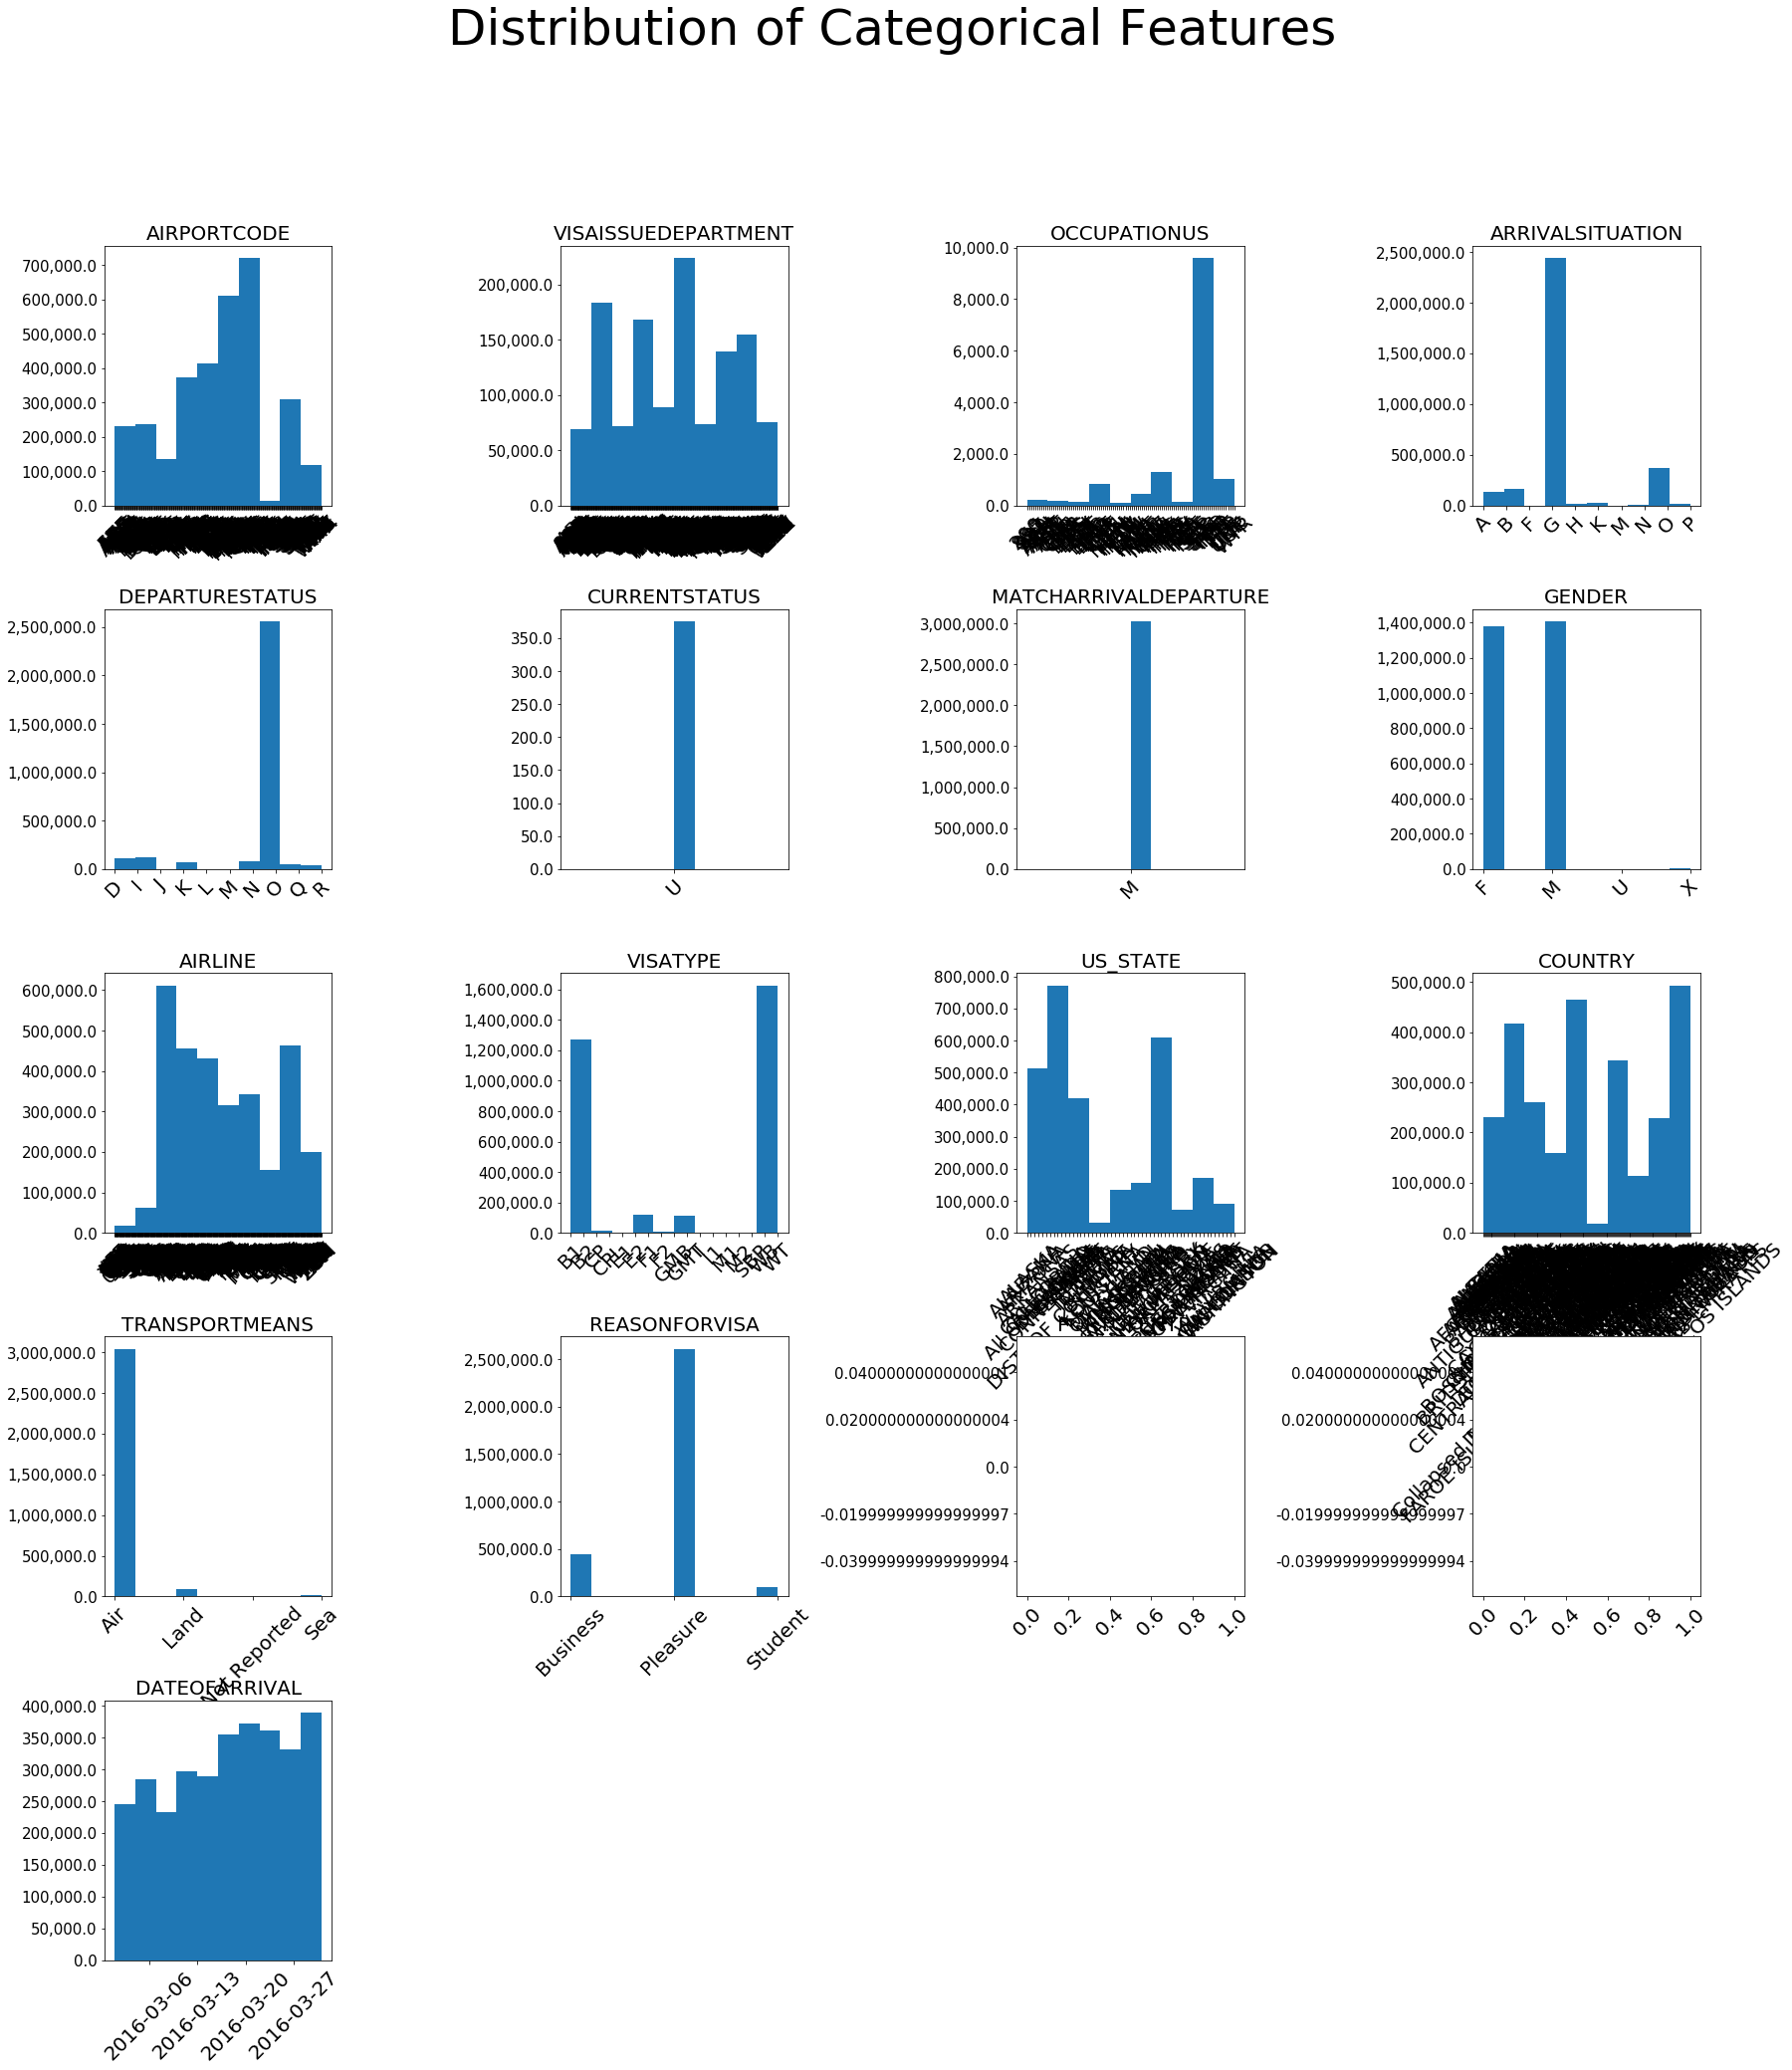

In [124]:
#Distribution of Categorical Data
#Idea picked from shared from Data Science for Everyone YouTube Channel
#https://github.com/markumreed/data_science_for_everyone/blob/main/pyspark_examples/pima_indians_diabetes_eda_pyspark.ipynb
fig = plt.figure(figsize=(30, 30))
st = fig.suptitle("Distribution of Categorical Features", fontsize=50, verticalalignment="center")
for col, num in zip(categorical, range(1,len(categorical)+1)):
    print("Plotting", col, ": Variable {}.".format(num))
    ax = fig.add_subplot(5,4, num)
    ax.hist(df_spark.select(F.collect_list(col)).first()[0])
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

#### *QUICK FACTS*

###### *TOP 10 Countries*

In [117]:
spark.sql("""SELECT Country, COUNT(*) AS Records 
             FROM Analysis
             GROUP BY Country 
             ORDER BY Records 
             DESC LIMIT 10 """).toPandas()

Country  Records
0            None   426629
1  UNITED KINGDOM   400118
2           JAPAN   266022
3          MEXICO   227555
4           CHINA   186941
5          BRAZIL   110778
6          FRANCE   108154
7       AUSTRALIA    87559
8           ITALY    85068
9           SPAIN    81631

###### *TOP 10 US STATE DESTINATIONS*

In [118]:
spark.sql("""SELECT US_State, COUNT(*) AS Records 
             FROM Analysis
             GROUP BY US_State 
             ORDER BY Records 
             DESC LIMIT 10 """).toPandas()

US_State  Records
0        FLORIDA   694386
1       NEW YORK   524046
2     CALIFORNIA   477069
3           None   190048
4         HAWAII   176540
5          TEXAS   145347
6           GUAM   119435
7         NEVADA   101078
8  MASSACHUSETTS    74434
9       ILLINOIS    70130

###### *TOP 10 AIRLINES*

In [119]:
spark.sql("""SELECT Airline, COUNT(*) AS Records 
             FROM Analysis
             GROUP BY Airline 
             ORDER BY Records 
             DESC LIMIT 10 """).toPandas()

Airline  Records
0      AA   335381
1      UA   291634
2      DL   267864
3      BA   199806
4      LH   120745
5      VS   116462
6    None   101573
7      JL    78065
8      KE    71204
9      AM    70471

#### *Query and store Data to be used for mapping*

###### *TRAVELLERS TO EACH US STATE 2016 March*

In [127]:
US_Visitors_State= spark.sql("""SELECT StateCodeUS, COUNT(*) AS Records 
                                 FROM Analysis
                                 GROUP BY StateCodeUS
                                 ORDER BY Records""").toPandas()

In [131]:
US_Visitors_State.to_csv("US_State_Visitors.csv")

###### *TOTAL TRAVELLERS TO BY EACH AIRPORT*

In [132]:
Airport_Visitors = spark.sql("""SELECT AirportCode, COUNT(*) AS Records 
                                 FROM Analysis
                                 GROUP BY AirportCode
                                 ORDER BY Records""").toPandas()

In [133]:
Airport_Visitors.to_csv("Airport_Visitors.csv")

###### *TOTAL TRAVELLERS TO BY EACH COUNTRY*

In [135]:
Country_Visitors = spark.sql("""SELECT Country, COUNT(*) AS Records 
                                 FROM Analysis
                                 GROUP BY Country
                                 ORDER BY Records""").toPandas()

In [137]:
Country_Visitors["CountryMatch"] = Country_Visitors["Country"].str.title()

In [139]:
Country_Visitors.to_csv("Country_Visitors.csv")

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model
1. Then main data is the I94 Immmigration data then the others are supplementary.
2. Being able to export insights for other systems to use like in this case the GIS mapping

#### 3.2 Mapping Out Data Pipelines
1. SAS data to RAW Parquet Data
2. Uploading Parquet Data to S3 for EMR to access and storage accessible from anywhere
3. Reading the Raw Parquet Data doing the following (Either on the Udacity workspace, locally or EMR from S3)
    1. Changing Column Names to meaningful human friendly names
    2. Schema Enforcement through type casting
    3. Joining some required tables e.g Country Codes e.t.c
    4. Exporting this to a new parquet ready for further upstream data analytics and futher processing
4. Data Quality Checks
5. Data Analysis (Exploraty Data Analysis (EDA), Futher Error Checking, Modelling e.t.c 
5. Exporting Key Insights to for GIS Map Making

#### Additional Potential Pipelines
1. EMR to RedShift (there is more processing required)
2. RedShift from Parquet export from stage 3
3. If Data gets more massive and more people require access then EMR to No SQL, Cassandra or DyanamoDB or from Parquet e.t.c

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [141]:
# these are functions that process data pretty much or push it somewhere or both
# the print statements will chane to logging for an AirFlow dag operator definition based on the functions here
#1 Convert SAS to Parquet
def sas_to_parquet(required_months:list):
    """
    Only works on the Udacity WorkSpace, it reads the attached drive with SAS files
    and converts them to a prescribed path that you can vary.
    Assumption is spark is already intiallized
    input e.g ['jan', 'feb'], similiar to months_list defined earlier
    """
    
    startTime = datetime.now()
    totalRecords = 0
    for month in required_months:
        startMonth = datetime.now()
        print(month)
        df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_{}16_sub.sas7bdat'.format(month))
        Records = df_spark.count()
        totalRecords += Records
        df_spark.write.parquet("sas_data_raw/2016/{}".format(months_data[month]))

        print((datetime.now() - startMonth), "time for SAS to Parquet", month, "with ", "{:,}".format(Records), " Records.")

    print((datetime.now() - startTime), "time running for 2016 SAS to Parquet with ", "{:,}".format(totalRecords), " total Records.")

#2 Push a whole folder with Parquet files from workspace to S3
def upload_files_to_s3(path, bucket_name, region):
    """
    Pushes a whole folder (path) with the same structure to an S3 bucket.
    Also shows progress for every 20 files and the total size in MD
    transferred so far or in Total
    """
    bytes_MB = 2**20
    start = datetime.now()
    session = boto3.Session(
        aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
        region_name=region#e.g'us-east-1'
    )
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
    totalsize, count = 0, 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            count+=1
            full_path = os.path.join(subdir, file)
            totalsize += os.path.getsize(full_path)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=subdir.replace("\\", '/')+'/'+file, Body=data)
            if (count%20) == 0:
                print(file, "Uploaded, {:,} files so far uploaded, {:,.2f} MB total, {} Time running".format(count, totalsize/bytes_MB , (datetime.now() - start)))
                
    overall = str(datetime.now() - startTime) + " Time running Uploaded, {:,} files uploaded, {:,.2f} MB total.".format(count, totalsize/bytes_MB)
    print(overall)
    print("COMPLETED")

#3 Process, Clean, Intergrate and Refine Parquet for Analysis
def parse_parquet_for_analysis(required_months:list):
    """
    This process the raw parquet dump from SAS by:
        1. Renaming Columns to having meaningful names
        2. Casting Columns to their required DataTypes
        3. Joining the data to the following datasets based on custom mappings:
            1. Country Codes Mapped to Country Names
            2. Port Codes mapped to Port Names
            3. Transport Codes mapped to Transport Classifications
            4. US State Codes mapped to US State Name
            5. Visa Reasons Codes mapped to Reasons for Visas
        4. Exporting this to a new parquet file ready for EDA and another futher analysis and cleaning
    """
    startTime = datetime.now()
    totalRecords = 0
    for month in required_months:
        startMonth = datetime.now()
        print(month)
        df_spark=spark.read.parquet("sas_data_raw/2016/{}".format(months_data[month]))
        u=list(i94s_label_map[key] for key in df_spark.columns) 
        Records = df_spark.count()
        totalRecords += Records
        df_spark = df_spark.toDF(*u)
        df_spark = df_spark.withColumn("DateOfArrival", convert_to_date("DateOfArrival"))
        df_spark = df_spark.withColumn("DateOfDeparture", convert_to_date("DateOfDeparture"))
        df_spark = df_spark.withColumn("DateAdmittedUS", convert_to_date2("DateAdmittedUS"))

        #Casting DataTypes
        df_spark  = df_spark.withColumn('i94_id', col('i94_id').cast('Integer'))\
                            .withColumn('Year', col('Year').cast('Integer'))\
                            .withColumn('Month', col('Month').cast('Integer'))\
                            .withColumn('CountryCode', col('CountryCode').cast('Integer'))\
                            .withColumn('CountryResidenceCode', col('CountryResidenceCode').cast('Integer'))\
                            .withColumn('ModeOfTransport', col('ModeOfTransport').cast('Integer'))\
                            .withColumn('VisaReason', col('VisaReason').cast('Integer'))\
                            .withColumn('CountVar', col('CountVar').cast('Integer'))\
                            .withColumn('YearofBirth', col('YearofBirth').cast('Integer'))\
                            .withColumn('AdminNum', col('AdminNum').cast('Integer'))
        
        #Reading Data to be joined to the DataFrame
        CountryCodes = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/Country_Codes.csv',header='True')
        PortCodes = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/Port_Codes.csv',header='True')
        TransportCodes = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/TransportMeansCode.csv',header='True')
        US_State_Codes = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/US_States.csv',header='True')
        VisaReasonsCodes = spark.read.csv('s3a://obirad1/Udacity/data-eng-capstone/data/VisaReasons.csv',header='True')
        
        #Joining to the other datasets and dropping the join id Columns after
        #Another option would be to use pyspark SQL views, this is much simpler for simple joins
        df_spark = df_spark.join(US_State_Codes, df_spark.StateCodeUS == US_State_Codes.Code, "left")
        df_spark = df_spark.drop(df_spark.Code)
        df_spark = df_spark.join(CountryCodes, df_spark.CountryCode == CountryCodes.Code, "left")
        df_spark = df_spark.drop(df_spark.Code)
        df_spark = df_spark.join(TransportCodes, df_spark.ModeOfTransport == TransportCodes.Code, "left")
        df_spark = df_spark.drop(df_spark.Code)
        df_spark = df_spark.join(VisaReasonsCodes, df_spark.VisaReason == VisaReasonsCodes.Code, "left")
        df_spark = df_spark.drop(df_spark.Code)
        df_spark = df_spark.join(PortCodes, df_spark.CountryCode == PortCodes.Code, "left")
        df_spark = df_spark.drop(df_spark.Code)

        #Writing the Parquet Files to local Storage, they will be pushed to S3
        #df_spark.write.parquet("s3a://obirad1/Udacity/data-eng-capstone/2016/{}".format(months_data[month])
        df_spark.write.parquet("sas_data/2016/{}".format(months_data[month]))
        #df_spark.write.mode('append').parquet("sas_data/2016/all/2016_all_data.parquet")

        #df_spark.write.mode('append').parquet("s3a://obirad1/Udacity/data-eng-capstone/2016/all")

        print((datetime.now() - startMonth), "time running for renaming and integration", month, "with ", "{:,}".format(Records), " Records.")
    print((datetime.now() - startTime), "time running for 2016 with ", "{:,}".format(totalRecords), " total Records.")

#4 Further automation can be done after the EDA, the issue is this only March Data, the exceptions may vary in another month, so this won't be hard coded,
# these will be figured out during the data analysis

#These can be built into DAGS using Airflow if need be

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [185]:
# Perform quality checks here

#Check Counts
def check_count(dataframe):
    """
    The Dataframe should have at least one Record
    """
    count = dataframe.count()
    if count > 0:
        print("Passed Count Check with {:,} Records".format(count))
    else:
        print("Failed No Data")

#Check Number of Columns
def check_columns(dataframe):
    """
    The Dataframe should have at least one 2 Columns
    """
    cols = len(dataframe.columns)
    if cols >= 2:
        print("Passed Column Check with {:,} Columns".format(cols))
    else:
        print("Failed Insufficent Columns")
        
        
def check_expectd_columns(dataframe, expectedcolumns):
    """
    The Dataframe should have at least one 2 Columns
    """
    cols = len(dataframe.columns)
    if cols == expectedcolumns:
        print("Passed Expected Column Check with {:,} Columns Expected ".format(cols))
    else:
        print("Failed Insufficent Columns, difference is {}, columns.".format(cols-expectedcolumns))
        
#Datatypes

#Values limit for some numeric fields
def checkValues(dataframe, column, valuelimits:list):
    """
    The Dataframe column values should be in the range (valuelimits[0] and valuelimits[1])
    """
    maxLimit = max(valuelimits)
    minLimit = min(valuelimits)
    
    cols_Min = dataframe.agg(F.min(column)).collect()[0][0]
    cols_Max = dataframe.agg(F.max(column)).collect()[0][0]
    
    if cols_Max <= maxLimit:
        if cols_Min >= minLimit:
            print("PASSED: Columns Values are with in range: MaxValue is {:,} and MinValue is {:,}.".format(cols_Max, cols_Min))
        else:
            print(" PARTIAL PASS: MinValue {:,} smaller than the limit Minimun {:,}.".format(cols_Min, minLimit))
    else:
        if cols_Min >= minLimit:
            print(" PARTIAL PASS: MaxValue  {:,} bigger than expected Maximun  {:,}.".format(cols_Max, maxLimit))
        else:
            print("FAILED: Columns Values are with not in the range:  {:,} to {:,}.".format(minLimit, maxLimit))

#Check Schema - Can check with a schema map

#Human Eye
#Max Length of a Character Variable if Enforcement is required
#Other checks can look at text values

#More checks can be added

check_count(df_spark)
check_columns(df_spark)
check_expectd_columns(df_spark, 34)
checkValues(df_spark, 'AgeYears', [0,120])
df_spark.printSchema()

Passed Count Check with 3,157,072 Records
Passed Column Check with 34 Columns
Passed Expected Column Check with 34 Columns Expected 
PASSED: Columns Values are with in range: MaxValue is 116 and MinValue is 0.
root
 |-- i94_id: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- CountryCode: integer (nullable = true)
 |-- CountryResidenceCode: integer (nullable = true)
 |-- AirportCode: string (nullable = true)
 |-- DateOfArrival: date (nullable = true)
 |-- ModeOfTransport: integer (nullable = true)
 |-- StateCodeUS: string (nullable = true)
 |-- DateOfDeparture: date (nullable = true)
 |-- AgeYears: integer (nullable = true)
 |-- VisaReason: integer (nullable = true)
 |-- CountVar: integer (nullable = true)
 |-- DateAdded_I94: string (nullable = true)
 |-- VisaIssueDepartment: string (nullable = true)
 |-- OccupationUS: string (nullable = true)
 |-- ArrivalSituation: string (nullable = true)
 |-- DepartureStatus: string (nullable 

#### Mapping Results

#### *Visitors by US State, March 2016*

In [15]:
uspath = r'GIS_Data\US\US_States.shp'
usa = geopandas.read_file(uspath)

In [16]:
usa.columns

Index(['GID_1', 'GID_0', 'COUNTRY', 'NAME_1', 'VARNAME_1', 'TYPE_1', 'HASC_1',
       'ISO_1', 'StateUS', 'geometry'],
      dtype='object')

In [17]:
usa[['GID_1','NAME_1','TYPE_1', 'HASC_1', 'ISO_1', 'StateUS']].head()

GID_1      NAME_1 TYPE_1 HASC_1  ISO_1 StateUS
0  USA.1_1     Alabama  State  US.AL  US-AL      AL
1  USA.3_1     Arizona  State  US.AZ  US-AZ      AZ
2  USA.4_1    Arkansas  State  US.AR  US-AR      AR
3  USA.5_1  California  State  US.CA  US-CA      CA
4  USA.6_1    Colorado  State  US.CO  US-CO      CO

In [24]:
us_state_visitors = pd.read_csv(r"Analysis_Output\US_State_Visitors.csv")

In [35]:
usa=usa.merge(us_state_visitors, left_on='StateUS', right_on='StateCodeUS')

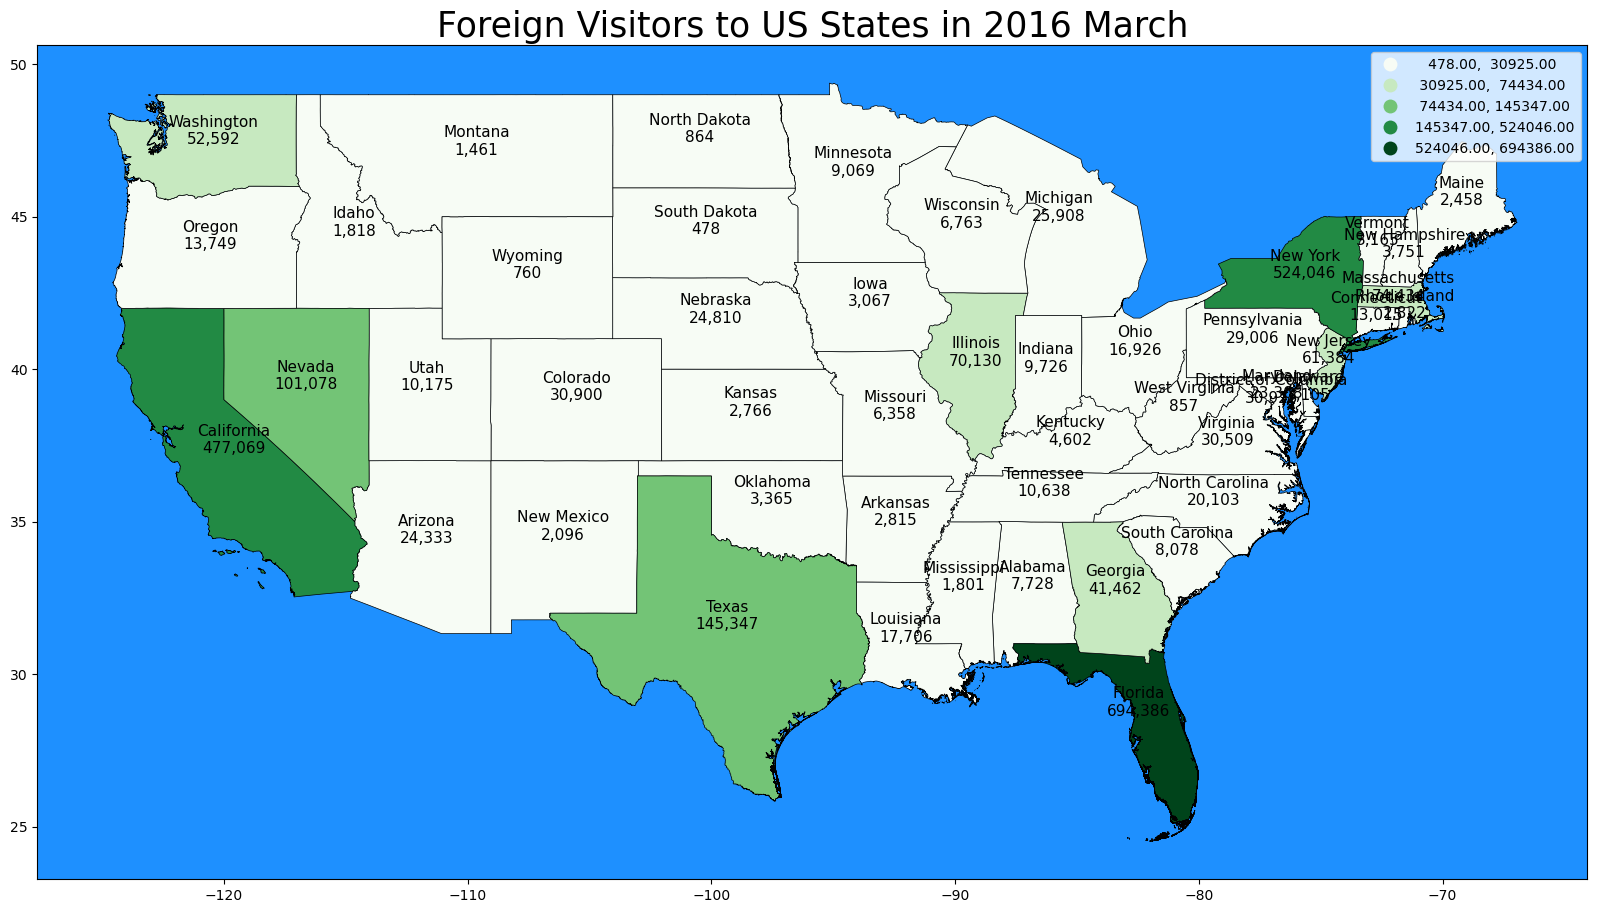

In [39]:
fig, ax = plt.subplots(figsize=(20, 15))
usa.plot('Records', legend=True, scheme='NaturalBreaks', ax=ax, cmap="Greens", edgecolor="black", linewidth=.5)
usa.apply(lambda x: ax.annotate(text=x['NAME_1'] +"\n"+'{:,}'.format(x['Records']), xy=x.geometry.centroid.coords[0], ha='center', fontsize=11), axis=1);
ax.set_title('Foreign Visitors to US States in 2016 March', fontdict={'fontsize':25, 'fontweight':3});
ax.set_facecolor(water)

#### *Visitors by Country, March 2016*

In [12]:
world.columns

Index(['LABELRANK', 'SOVEREIGNT', 'TYPE', 'ADMIN', 'ADM0_A3', 'GEOUNIT',
       'SUBUNIT', 'NAME', 'NAME_LONG', 'ABBREV', 'FORMAL_EN', 'FORMAL_FR',
       'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY',
       'INCOME_GRP', 'ISO_A2', 'ISO_A2_EH', 'ISO_A3', 'ISO_A3_EH', 'ISO_N3',
       'ISO_N3_EH', 'UN_A3', 'WB_A2', 'WB_A3', 'WOE_ID', 'ADM0_ISO',
       'ADM0_DIFF', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB',
       'geometry'],
      dtype='object')

In [40]:
world_visitors = pd.read_csv(r'Analysis_Output\Country_Visitors.csv')

In [43]:
world = world.merge(world_visitors, left_on='NAME', right_on='CountryMatch')

In [13]:
world[['LABELRANK', 'NAME', 'NAME_LONG', 'ABBREV',
       'POP_EST', 'POP_RANK', 'POP_YEAR', 'GDP_MD', 'GDP_YEAR', 'ECONOMY',
       'INCOME_GRP', 'ISO_A2', 'ISO_A3', 'CONTINENT', 'REGION_UN', 'SUBREGION', 'REGION_WB']].head()

LABELRANK       NAME  NAME_LONG   ABBREV        POP_EST  POP_RANK  \
0          2  Indonesia  Indonesia    Indo. 270,625,568.00        17   
1          3   Malaysia   Malaysia   Malay.  31,949,777.00        15   
2          2      Chile      Chile    Chile  18,952,038.00        14   
3          3    Bolivia    Bolivia  Bolivia  11,513,100.00        14   
4          2       Peru       Peru     Peru  32,510,453.00        15   

   POP_YEAR   GDP_MD  GDP_YEAR                   ECONOMY  \
0      2019  1119190      2019  4. Emerging region: MIKT   
1      2019   364681      2019      6. Developing region   
2      2019   282318      2019   5. Emerging region: G20   
3      2019    40895      2019   5. Emerging region: G20   
4      2019   226848      2019   5. Emerging region: G20   

               INCOME_GRP ISO_A2 ISO_A3      CONTINENT REGION_UN  \
0  4. Lower middle income     ID    IDN           Asia      Asia   
1  3. Upper middle income     MY    MYS           Asia      Asia   
2  3. Upper middle income     CL    CHL  South America  Americas   
3  4. Lower middle income     BO    BOL  South America  Americas   
4  3. Upper middle income     PE    PER  South America  Americas   

            SUBREGION                  REGION_WB  
0  South-Eastern Asia        East Asia & Pacific  
1  South-Eastern Asia        East Asia & Pacific  
2       South America  Latin America & Caribbean  
3       South America  Latin America & Caribbean  
4       South America  Latin America & Caribbean

In [ ]:
#world[world['NAME']=='Uganda']['geometry'].area

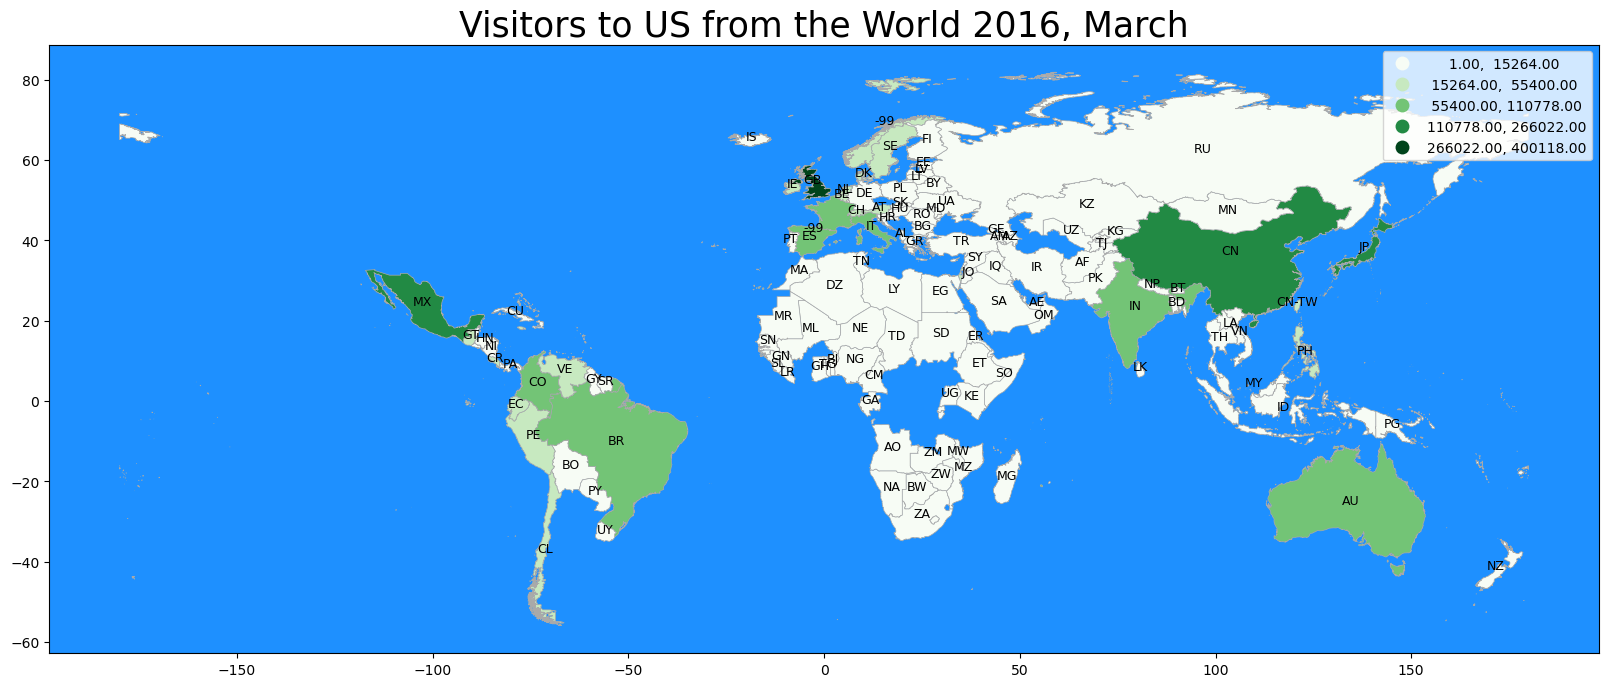

In [45]:
fig, ax = plt.subplots(figsize=(20, 15))
#world.plot('NAME', legend=False, ax=ax)
world.plot('Records', legend=True, scheme='NaturalBreaks', ax=ax, cmap="Greens", edgecolor="darkgrey", linewidth=0.5)
#world.boundary.plot('Greys_r', ax=ax, linewidth=0.5)
world.apply(lambda x: ax.annotate(text=x['ISO_A2'] if x['geometry'].area >3 else '', xy=x.geometry.centroid.coords[0], ha='center', fontsize=9), axis=1);
ax.set_title('Visitors to US from the World 2016, March', fontdict={'fontsize':25, 'fontweight':3});
ax.set_facecolor(water)

#### *Visitors by Airport, March 2016*

In [46]:
Airport_visitors = pd.read_csv(r'Analysis_Output\Airport_Visitors.csv')

In [51]:
US_Airports = Airports[Airports['iso_country']=='US']

In [54]:
Airports_with_Visitors = US_Airports.merge(Airport_visitors, left_on='iata_code', right_on='AirportCode')

In [62]:
airport_gdf = geopandas.GeoDataFrame(Airports_with_Visitors, 
                                     geometry=geopandas.points_from_xy(Airports_with_Visitors.lat,
                                                                       Airports_with_Visitors.long))

In [100]:
airport_gdf['Label'] = airport_gdf['name'].str.replace('Airport', '')

In [91]:
airport_gdf[['Records']].describe(include='all')

Records
count     135.00
mean   10,654.76
std    45,847.78
min         1.00
25%         8.50
50%        47.00
75%       543.50
max   441,151.00

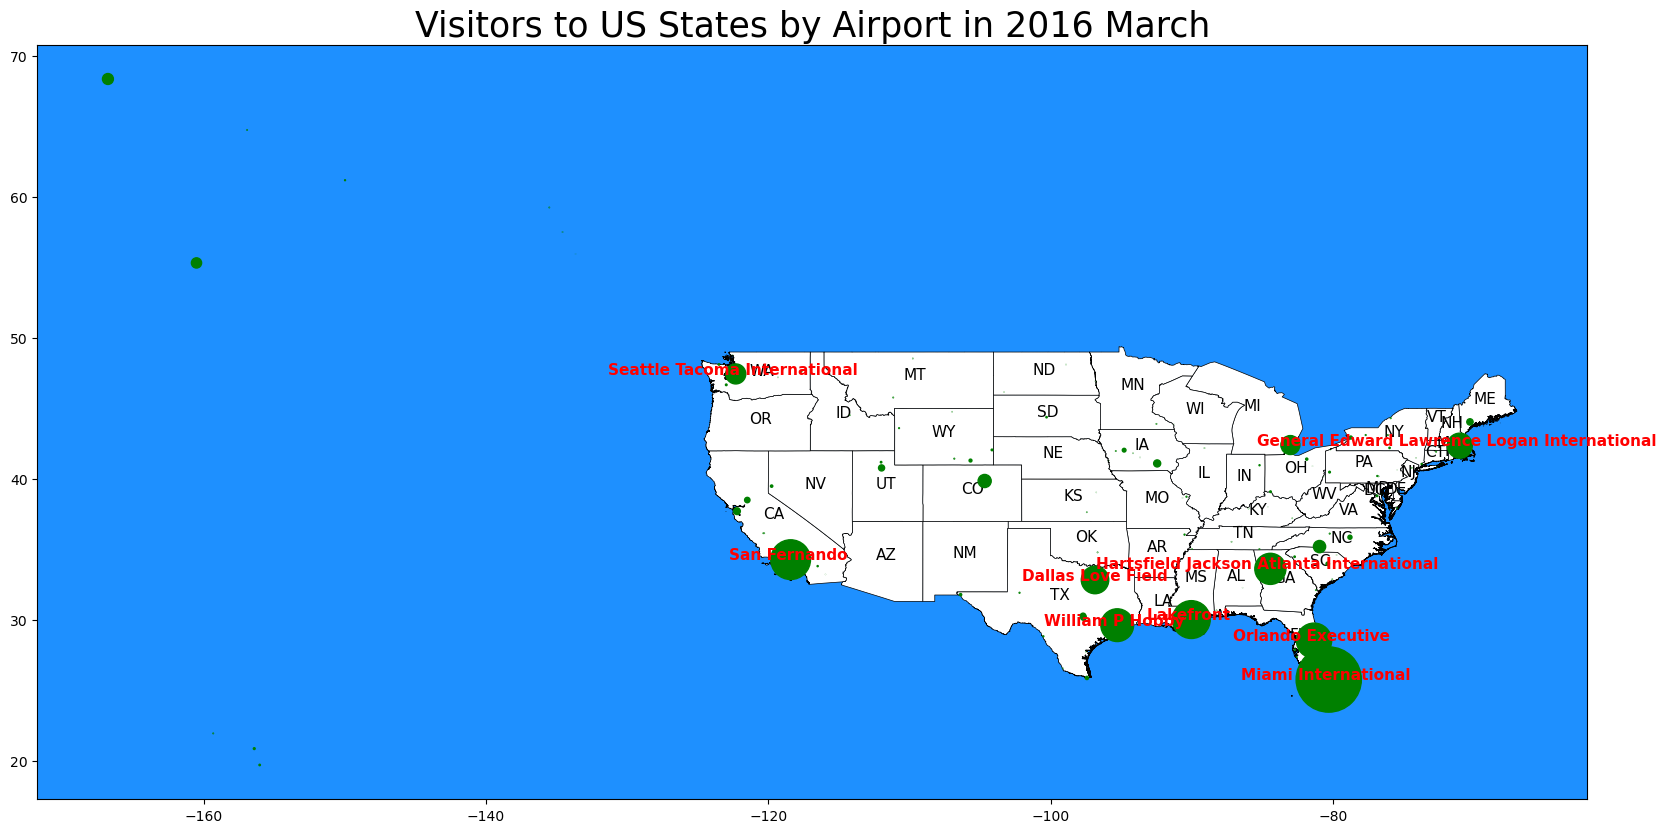

In [110]:
fig, ax = plt.subplots(figsize=(20, 15))
mapus = usa.boundary.plot(ax=ax, facecolor = "white", edgecolor="black", linewidth=.5, zorder=1)
usa.apply(lambda x: mapus.annotate(text=x['StateUS'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=11), axis=1);
airport_gdf.plot(ax=ax, markersize=airport_gdf['Records']/200, color='green', zorder=3)
airport_gdf.apply(lambda x: ax.annotate(text=x['Label'] if x['Records'] >40_000 else '', xy=x.geometry.centroid.coords[0], ha='center', fontsize=11, color="red", weight='bold'), axis=1);
ax.set_title('Visitors to US States by Airport in 2016 March', fontdict={'fontsize':25, 'fontweight':3});
ax.set_facecolor(water)
plt.show()

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

In [ ]:
geopandas.datasets.get_path('naturalearth_lowres')

In [ ]:
one = r'D:\Study\Udacity\Data Enginner Nano Degree\05_Data Engineering Capstone Project\Files\Intergrate\world-administrative-boundaries\world-administrative-boundaries.shp'

In [ ]:
world2 = geopandas.read_file(one)

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [ ]:
fig, ax = plt.subplots(figsize=(18, 12))
world.plot('name', legend=False, ax=ax)
#world.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1);

In [ ]:
world.columns

In [ ]:
#fig, ax = plt.subplots(1, 1)
world.explore('name', legend=True)

In [ ]:
world.explore('pop_est', legend=True)

In [ ]:
fig, ax = plt.subplots(figsize=(18, 12))
world.plot('pop_est', legend=True,cmap='OrRd', scheme='quantiles', ax=ax)

In [ ]:
dir(geopandas.datasets.get_path)

In [ ]:
fig, ax = plt.subplots(figsize=(24, 18))
world.plot(ax=ax, alpha=0.4, color="grey")

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
1. I picked Parquet as the primary data format because of the massive compression abillity,  it is faster to load, easy to move between systems and is also supported by several languages and big data tools.
2. S3 for Storage for universal access, EMR access and ease to share.
3. I used Geopandas to do making because it the primary mapping package other than ArcGIS and I wanted to summarize the results on some maps.
4. EMR is good for large scale ingestion, it would have ingested all the 40 million records easily and then custom analysis scan be done.

* Propose how often the data should be updated and why.
Data should be updated twice daily on a minimum if possible hourly or every half hour at least.

The main reason is the scale of events, at least 200,000 people were moving each day of March, losing a hour is alot of data.

* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.
 
 1. Parquet would still be the primary data format.
 2. Pipelines would be scheduled every 15 mins binning data to parquet, on network and S3
 3. A NO SQL database either Cassandra or DyanamoDB for live or latest data access set to Eventual Consitency
 4. EMR to ingest data every 6 Hours, clean it and process it.
 5. A permanent RedShift Cluster updated from EMR Routinely, this is where all key analyis would happen